# Cluster and HII-regions Multi <a class="tocSkip">

the aim of this notebook is to combine the HII-region and cluster catalogues.
   
This notebook useses multiple galaxies at once.

In [ ]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from astrotools.packages import *
from astrotools.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)


# first we need to specify the path to the raw data
basedir = Path('..')
data_ext = Path('a:')/'Archive' #basedir / 'data' / 'raw' 

sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])
sample_table['power_index'] = 2.3
sample_table['power_index'][sample_table['AO'].mask]=2.8
sample_table['distance'] = Distance(distmod=sample_table['(m-M)'])

## Read in data

In [ ]:
# the association catalogue matched with the nebuale catalogue
version = 'v1p2'
for HSTband in ['nuv','v']:
    for scalepc in [8,16,32,64]:
        folder = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'
        lst = []
        for file in folder.glob(f'*{scalepc}pc_associations.fits'):
            gal_name = file.stem.split('_')[0]
            tbl = Table(fits.getdata(file,ext=1))
            tbl.add_column(gal_name,name='gal_name',index=0)
            lst.append(tbl)
        assoc_tmp = vstack(lst)
        # missing = set(sample_table['name']) - set(np.unique(assoc_tmp['gal_name']))
        print(f'{HSTband:>3}, {scalepc:>2}pc: {len(lst)} galaxies, {len(assoc_tmp):>5} associations ({np.sum(assoc_tmp["1to1"]):>4} 1to1)')

In [ ]:
# choose which version of the association catalogue to use
version = 'v1p2'
HSTband = 'nuv'
scalepc = 32

### The nebulae catalogue

In [ ]:
# the original catalogue from Francesco
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_v2p1.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')
HIIregion_mask = (nebulae['BPT_NII']==0) & (nebulae['BPT_SII']==0) & (nebulae['BPT_OI']==0)

nebulae.rename_columns(['cen_x','cen_y','cen_ra','cen_dec','region_area',
                          'EBV','EBV_ERR','SkyCoord'],
                         ['x_neb','y_neb','ra_neb','dec_neb','area_neb',
                          'EBV_balmer','EBV_balmer_err','SkyCoord_neb'])
    
# some additional properties 
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_dig.fits') as hdul:
    dig = Table(hdul[1].data)
dig['dig/hii'] = dig['dig_median'] / dig['hii_median']

with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_fuv.fits') as hdul:
    fuv = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_eq.fits') as hdul:
    eq_width = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_density.fits') as hdul:
    density = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_refitNII.fits') as hdul:
    refitNII = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_in_frame.fits') as hdul:
    in_frame = Table(hdul[1].data)
    
nebulae = join(nebulae,fuv,keys=['gal_name','region_ID'])
nebulae = join(nebulae,eq_width,keys=['gal_name','region_ID'])
nebulae = join(nebulae,dig,keys=['gal_name','region_ID'])
nebulae = join(nebulae,density,keys=['gal_name','region_ID'])
nebulae = join(nebulae,refitNII,keys=['gal_name','region_ID'])
nebulae = join(nebulae,in_frame,keys=['gal_name','region_ID'])

# this will rais a few errors that we just ignore
with np.errstate(divide='ignore',invalid='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    #SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    SIII = (1+2.47)*nebulae['SIII9068_FLUX_CORR']
    nebulae['[SIII]/[SII]'][SII>0] = SIII[SII>0]/SII[SII>0]
    nebulae['[SIII]/[SII]_err'] = np.sqrt( ( ((3.47*nebulae['SIII9068_FLUX_CORR'])**2)*SII**2 + (nebulae['SII6716_FLUX_CORR_ERR']**2+nebulae['SII6730_FLUX_CORR_ERR']**2)*SIII**2) / SII**4)

    nebulae['HA/FUV_corr'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    nebulae['HA/FUV_corr_err'] = nebulae['HA/FUV_corr']*np.sqrt((nebulae['FUV_FLUX_CORR_ERR']/nebulae['FUV_FLUX_CORR'])**2+(nebulae['HA6562_FLUX_CORR_ERR']/nebulae['HA6562_FLUX_CORR'])**2)
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX']/nebulae['FUV_FLUX']
    nebulae['HA/FUV_err'] = nebulae['HA/FUV']*np.sqrt((nebulae['FUV_FLUX_ERR']/nebulae['FUV_FLUX'])**2+(nebulae['HA6562_FLUX_ERR']/nebulae['HA6562_FLUX'])**2)

    # remove temperatures with low S/N
    nebulae['temperature'][nebulae['NII5754_FLUX_CORR']/nebulae['NII5754_FLUX_CORR_ERR']<10] = np.nan
    nebulae['density'][nebulae['SII6730_FLUX_CORR']/nebulae['SII6730_FLUX_CORR_ERR']<10] = np.nan

    #nebulae['HA/FUV'] = nebulae['HA_conv_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    #nebulae['HA/FUV_err'] = nebulae['HA/FUV']*np.sqrt((nebulae['FUV_FLUX_CORR_ERR']/nebulae['FUV_FLUX_CORR'])**2+(nebulae['HA_conv_FLUX_CORR_ERR']/nebulae['HA_conv_FLUX_CORR'])**2)
    
nebulae['distance'] = np.nan
for gal_name in np.unique(nebulae['gal_name']):
    distance = Distance(distmod=sample_table.loc[gal_name]['(m-M)'])
    nebulae['distance'][nebulae['gal_name']==gal_name] = distance
nebulae['HA6562_LUM_CORR'] = (nebulae['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2 *4*np.pi*(nebulae['distance']*u.Mpc)**2).to(u.erg/u.s)

# the nebulae catalogue with additional information
folder = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'
lst = []
for file in folder.glob(f'*{scalepc}pc_nebulae.fits'):
    gal_name = file.stem.split('_')[0]
    tbl = Table(fits.getdata(file,ext=1))
    tbl.add_column(gal_name,name='gal_name',index=0)
    name=gal_name.lower()
    lst.append(tbl)
nebulae_tmp = vstack(lst)

nebulae = join(nebulae,nebulae_tmp,keys=['gal_name','region_ID'],join_type='outer')

print(f'{len(nebulae)} nebulae in initial catalogue (all galaxies)')
print(f'{len(np.unique(fuv[~np.isnan(fuv["FUV_FLUX"])]["gal_name"]))} galaxies with AstroSat ({np.sum(~np.isnan(fuv["FUV_FLUX"]))} regions)')
print(f'we use {len(lst)} galaxies with {np.sum(HIIregion_mask & ~nebulae["overlap_neb"].mask)} HII regions')
# only use HII regions and only the galaxies with associations
#nebulae = nebulae[HIIregion_mask & ~nebulae["overlap_neb"].mask]
nebulae = nebulae[HIIregion_mask]
print(f'{np.sum(nebulae["overlap_neb"]>0)} HII regions ({100*np.sum(nebulae["overlap_neb"]>0)/len(nebulae):.1f}%) overlap with association')

### The association catalogue

In [ ]:
# those files hold the merged association catalogues
with fits.open(basedir/'data'/'interim'/f'phangshst_associations_{HSTband}_ws{scalepc}pc_{version}.fits') as hdul:
    associations = Table(hdul[1].data)
    
associations['SkyCoord'] = SkyCoord(associations['reg_ra']*u.degree,associations['reg_dec']*u.degree)
associations.rename_columns(['reg_ra','reg_dec','reg_x','reg_y',
                             'reg_dolflux_Age_MinChiSq','reg_dolflux_Mass_MinChiSq','reg_dolflux_Ebv_MinChiSq',
                             'reg_dolflux_Age_MinChiSq_err','reg_dolflux_Mass_MinChiSq_err','reg_dolflux_Ebv_MinChiSq_err',
                             'SkyCoord'],
                            ['ra_asc','dec_asc','x_asc','y_asc','age','mass',
                             'EBV_stars','age_err','mass_err','EBV_stars_err','SkyCoord_asc'])

with fits.open(basedir/'data'/'interim'/f'association_CO_{HSTband}_ws{scalepc}pc_{version}.fits') as hdul:
    assoc_CO = Table(hdul[1].data)
associations = join(associations,assoc_CO,keys=['gal_name','assoc_ID'])

# Halpha measured in the association masks
#with fits.open(basedir/'data'/'interim'/f'phangshst_associations_nuv_ws32pc_v1p1_Halpha.fits') as hdul:
#    assoc_Halpha = Table(hdul[1].data)

with fits.open(basedir/'data'/'interim'/f'phangshst_associations_{HSTband}_ws{scalepc}pc_{version}_in_frame.fits') as hdul:
    in_frame = Table(hdul[1].data)
associations = join(associations,in_frame,keys=['gal_name','assoc_ID'])

# the association catalogue matched with the nebuale catalogue
folder = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'
lst = []
for file in folder.glob(f'*{scalepc}pc_associations.fits'):
    gal_name = file.stem.split('_')[0]
    #print(f'reading {gal_name}')
    tbl = Table(fits.getdata(file,ext=1))
    tbl.add_column(gal_name,name='gal_name',index=0)
    lst.append(tbl)
assoc_tmp = vstack(lst)
# combine both catalogues
associations = join(associations,assoc_tmp,keys=['gal_name','assoc_ID'])
print(f'{len(lst)} galaxies in sample ({len(associations)} associations)')
print(f'{np.sum(associations["overlap_asc"]>0)} associations ({100*np.sum(associations["overlap_asc"]>0)/len(associations):.1f}) overlap with an HII region')

#criteria = np.abs(associations['age']-associations['age_16'])>associations['age_err']
#criteria |= np.abs(associations['age']-associations['age_64'])>associations['age_err']
#associations['uniform_age'] = ~criteria

### The joined catalogue

In [ ]:
# we can also recreate the table from the association an nebulae catalogues
catalogue = join(nebulae[~nebulae['assoc_ID'].mask],associations,keys=['gal_name','assoc_ID','region_ID'])

# add dig and calculate galactic radius
catalogue['galactic_radius'] = np.nan
for gal_name in np.unique(catalogue['gal_name']):
    centre = sample_table.loc[gal_name]['SkyCoord']
    catalogue['galactic_radius'][catalogue['gal_name']==gal_name] = catalogue[catalogue['gal_name']==gal_name]['SkyCoord_neb'].separation(centre).to(u.arcmin)
#catalogue['HA/NUV'] = catalogue['HA6562_FLUX_CORR']/catalogue['NUV_FLUX']/1e20
    
#del catalogue[['SkyCoord_asc','SkyCoord_neb']]
#hdu = fits.BinTableHDU(catalogue,name='matched catalogue')
#hdu.writeto(basedir/'data'/'interim'/f'matched_catalogue_{HSTband}_ws{scalepc}pc_{version}.fits',overwrite=True)

    
print(f'{len(catalogue)} objects in final catalogue')

In [ ]:
hst_sample      = set(np.unique(associations['gal_name']))
astrosat_sample = set(np.unique(nebulae[~np.isnan(nebulae['FUV_FLUX'])]['gal_name']))
muse_sample     = set(sample_table['name'])
complete_sample = hst_sample & astrosat_sample & muse_sample


print(f'nebulae: {len(nebulae[np.isin(nebulae["gal_name"],list(hst_sample))])}')
print(f'associations: {len(associations)} from {len(hst_sample)} galaxies')
print(f'FUV: {len(astrosat_sample & hst_sample)} galaxies')
print(f'match: {len(catalogue)}')
print(f'contained: {len(catalogue[catalogue["overlap"]=="contained"])}')

### Table to showcase the sample

In [ ]:
astrosat_sample = np.unique(nebulae[~np.isnan(nebulae['FUV_FLUX'])]['gal_name'])
muse_sample     = sample_table['name']
hst_sample      = associations['gal_name']
sitelle_sample  = ['NGC0628','NGC2835','NGC3351','NGC3627','NGC4535']

t = Table({
    'name':muse_sample,
    'MUSE':np.isin(muse_sample,muse_sample),
    'HST':np.isin(muse_sample,hst_sample),
    'Astrosat':np.isin(muse_sample,astrosat_sample),
    'Sitelle':np.isin(muse_sample,sitelle_sample)}
     )

for col in t.columns[1:]:
    t[col] = ['\checkmark' if x else '' for x in t[col] ]
ascii.write(t,sys.stdout, Writer = ascii.Latex)

sample table for paper

In [ ]:
latexdict = {'tabletype': 'table*',
'header_start': '\\toprule',
'header_end': '\\midrule',
'data_end': '\\bottomrule',
'caption': f'Galaxy sample',
'units': {'R.A.':'(J2000)','Dec.':'(J2000)','$i$':'deg','PA':'deg','Distance':'$\si{\mega\parsec}$',
          'r25':'arcmin'},
'preamble': '\\centering',
'tablefoot': f'\\label{{tbl:sample}}'
            }

tbl = sample_table[['name','Type','R.A.','Dec.','Inclination','posang','r25','mass','SFR','PSF','(m-M)']]

tbl['R.A.'] = [row.replace('h','x').replace('m','y').replace('.','z').replace('s','') for row in tbl['R.A.']]
tbl['R.A.'] = [row.replace('x','$^\mathrm{h}$').replace('y','$^\mathrm{m}$').replace('z','$^\mathrm{s}\kern -3pt.$') for row in tbl['R.A.']]

tbl['Dec.'] = [row.replace('d','x').replace('m','y').replace('.','z').replace('s','') for row in tbl['Dec.']]
tbl['Dec.'] = [row.replace('-','$-$').replace('+','$+$').replace('x','$^\mathrm{d}$').replace('y','$^\mathrm{m}$').replace('z','$^\mathrm{s}\kern -3pt.$') for row in tbl['Dec.']]
tbl.add_column(Distance(distmod=tbl['(m-M)']).to(u.Mpc),index=4,name='Distance')
tbl['Distance'].info.format = '%.2f' 
tbl['Nneb'] = [np.sum((nebulae['gal_name']==name) & (nebulae['in_frame'])) for name in tbl['name']]
tbl['Nasc'] = [np.sum((associations['gal_name']==name) & (associations['in_frame'])) for name in tbl['name']]

#tbl['name'] = [f'\\galaxyname{{{row["name"][:-4]}}}{{{row["name"][-4:]}}}' for row in tbl]
tbl.rename_columns(['Inclination','posang','r25'],['$i$','PA','$r_{25}$'])
#tbl = join(tbl,t,keys='name')

#with open(basedir / 'data' / 'interim' /'sample.tex','w',newline='\n') as f:
#    ascii.write(tbl,f,Writer=ascii.Latex, latexdict=latexdict,overwrite=True,exclude_names=['(m-M)','Sitelle'])
ascii.write(tbl,sys.stdout, Writer = ascii.Latex,latexdict=latexdict,exclude_names=[])

In [ ]:
latexdict = {'tabletype': 'table',
'col_align':'lrrrrc',
'header_start': '\\toprule',
'header_end': '\\midrule',
'data_end': '\\bottomrule',
'caption': f'Galaxy sample',
'units': {'R.A.':'(J2000)','Dec.':'(J2000)','$i$':'deg','PA':'deg','Distance':'$\si{\mega\parsec}$',
          'r25':'arcmin'},
'preamble': '\\centering',
'tablefoot': f'\\label{{tbl:sample}}'
            }

astrosat_sample = np.unique(nebulae[~np.isnan(nebulae['FUV_FLUX'])]['gal_name'])

tbl = sample_table[['name','(m-M)']]
tbl.sort('name')
tbl.add_column(Distance(distmod=tbl['(m-M)']).to(u.Mpc),index=1,name='Distance')
tbl['Distance'].info.format = '%.2f' 
del tbl['(m-M)']
tbl[r'$N_{\HII}$'] = [np.sum((nebulae['gal_name']==name) & (nebulae['in_frame'])) for name in tbl['name']]
tbl[r'$N_\mathrm{asc}$'] = [np.sum((associations['gal_name']==name) & (associations['in_frame'])) for name in tbl['name']]
tbl[r'$N_\mathrm{match}$'] = [np.sum(catalogue['gal_name']==name) for name in tbl['name']]
tbl.add_column([f'\\galaxyname{{{row["name"][:-4]}}}{{{row["name"][-4:]}}}' for row in tbl],index=0,name='Name')

tbl['\\textit{AstroSat}'] = ['\checkmark' if x else '' for x in np.isin(tbl['name'],astrosat_sample)]
del tbl['name']

tbl.add_row(['',None,np.sum(nebulae['in_frame']),np.sum(associations['in_frame']),len(catalogue),''])
ascii.write(tbl,sys.stdout, Writer = ascii.Latex,latexdict=latexdict,exclude_names=[])

### Plot the sample (cutouts)

plot all objects in the merged catalogues

In [ ]:
from cluster.io import read_associations
from matplotlib.backends.backend_pdf import PdfPages
from cluster.plot import single_cutout


criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=10) 
criteria &= (catalogue['overlap_neb']>0.1) 
criteria &= (catalogue['overlap_asc']==1) 
criteria &= (catalogue['neighbors']==0)

tmp = catalogue[criteria]

print(f'{len(tmp)} objects in sample')

size=10*u.arcsec
nrows=5
ncols=4
filename = basedir/'reports'/f'cutouts_{HSTband}_{scalepc}pc'
    
width = 8.27
N = len(tmp) 
Npage = nrows*ncols-1
if N%Npage==0:
    print('sample size % subplots = 0: no subplot for legend')
Npages = int(np.ceil(N/Npage))
gal_name = None

with PdfPages(filename.with_suffix('.pdf')) as pdf:

    for i in range(Npages):
        print(f'working on page {i+1} of {Npages}')

        sub_sample = tmp[i*Npage:(i+1)*Npage]

        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
        axes_iter = iter(axes.flatten())

        for row in sub_sample:  
            
            # for a new galaxy we need to read in the masks/images
            if row['gal_name'] != gal_name:
                
                gal_name = row['gal_name']
                
                # HST image for the background
                filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_exp-drc-sci.fits'
                with fits.open(filename) as hdul:
                    F275 = NDData(hdul[0].data,
                                  mask=hdul[0].data==0,
                                  meta=hdul[0].header,
                                  wcs=WCS(hdul[0].header))
                
                # nebulae mask
                filename = data_ext / 'Products' / 'Nebulae_catalogs' / 'Nebulae_catalogue_v2' /'spatial_masks'/f'{gal_name}_nebulae_mask.fits'
                with fits.open(filename) as hdul:
                    nebulae_mask = NDData(hdul[0].data.astype(float),meta=hdul[0].header,wcs=WCS(hdul[0].header))
                    nebulae_mask.data[nebulae_mask.data==-1] = np.nan
                
                # association mask
                associations_mask = read_associations(folder=data_ext/'Products'/'stellar_associations',
                                                      target=gal_name.lower(),
                                                      scalepc=scalepc,
                                                      data='mask')

            
            ax = next(axes_iter)
            ax = single_cutout(ax,
                             position = row['SkyCoord_neb'],
                             image = F275,
                             mask1 = nebulae_mask,
                             mask2 = associations_mask,
                             label = f"{row['gal_name']}: {row['region_ID']:.0f}/{row['assoc_ID']:.0f}",
                             size  = 4*u.arcsecond)

        plt.subplots_adjust(wspace=-0.01, hspace=0.05)

        # only the last page has subplots that need to be removed
        h,l = fig.axes[0].get_legend_handles_labels()
        ax = next(axes_iter)
        ax.axis('off')
        ax.legend(h[::len(h)-1],l[::(len(l)-1)],fontsize=7,loc='center',frameon=False)
        t = ax.text(0.07,0.87,'name: region ID/assoc ID', transform=ax.transAxes,color='black',fontsize=8)

        if i == int(np.ceil(N/Npage))-1:

            for i in range(nrows*ncols-len(sub_sample)-1):
                # remove the empty axes at the bottom
                ax = next(axes_iter)
                ax.axis('off')    

        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

three color composit with CO emission

In [ ]:
from cluster.io import read_associations
from matplotlib.backends.backend_pdf import PdfPages
from reproject import reproject_interp
from skimage.measure import find_contours
from pnlf.plot import create_RGB


criteria = (catalogue['mass']>1e4) 
criteria &= (catalogue['overlap_asc'] == 1)
criteria &= (catalogue['age'] < 10)
#tmp = catalogue[criteria]

print(f'{len(tmp)} objects')

size=5*u.arcsec
nrows=5
ncols=4
filename = basedir/'reports'/f'cutouts_rgb_{HSTband}_{scalepc}pc'

width = 8.27
N = len(tmp) 
Npage = nrows*ncols-1
if N%Npage==0:
    print('sample size % subplots = 0: no subplot for legend')
Npages = int(np.ceil(N/Npage))
gal_name = None

with PdfPages(filename.with_suffix('.pdf')) as pdf:

    for j in range(Npages):
        print(f'working on page {j+1} of {Npages}')

        sub_sample = tmp[j*Npage:(j+1)*Npage]

        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
        axes_iter = iter(axes.flatten())

        for row in sub_sample:  
            
            # for a new galaxy we need to read in the masks/images
            if row['gal_name'] != gal_name:
                
                gal_name = row['gal_name']
                print(f'reading files for {gal_name}')
                
                # HST image for the background
                filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_exp-drc-sci.fits'
                with fits.open(filename) as hdul:
                    F275 = NDData(hdul[0].data,
                                  mask=hdul[0].data==0,
                                  meta=hdul[0].header,
                                  wcs=WCS(hdul[0].header))
                
                filename = data_ext/'MUSE'/'DR2.1'/'MUSEDAP'/ f'{gal_name}_MAPS.fits'
                with fits.open(filename) as hdul:
                    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                                    meta=hdul['HA6562_FLUX'].header,
                                    wcs=WCS(hdul['HA6562_FLUX'].header))
    
                # nebulae mask
                filename = data_ext/'Products'/ 'Nebulae catalogue'/'spatial_masks'/f'{gal_name}_nebulae_mask.fits'
                with fits.open(filename) as hdul:
                    nebulae_mask = NDData(hdul[0].data.astype(float),meta=hdul[0].header,wcs=WCS(hdul[0].header))
                    nebulae_mask.data[nebulae_mask.data==-1] = np.nan
                
                # association mask
                associations_mask = read_associations(folder=data_ext/'HST'/'stellar_associations',
                                                      target=gal_name.lower(),
                                                      scalepc=scalepc,
                                                      data='mask')
            
                with fits.open(data_ext/'ALMA'/'v4p0'/f'{gal_name.lower()}_12m+7m+tp_co21_broad_tpeak.fits') as hdul:
                    CO = NDData(data=hdul[0].data,
                                meta=hdul[0].header,
                                wcs=WCS(hdul[0].header))
            
            ax = next(axes_iter)
            
            position = row['SkyCoord_neb']
            
            label = f"{row['gal_name']}: {row['region_ID']:.0f}/{row['assoc_ID']:.0f}"

            cutout_F275 = Cutout2D(F275.data,position,size=size,wcs=F275.wcs)
            norm = simple_norm(cutout_F275.data,stretch='linear',clip=False,percent=99.9)

            cutout_CO, _  = reproject_interp(CO,output_projection=cutout_F275.wcs,shape_out=cutout_F275.shape)    
            cutout_Halpha, _  = reproject_interp(Halpha,output_projection=cutout_F275.wcs,shape_out=cutout_F275.shape)    

            rgb = create_RGB(cutout_CO,cutout_Halpha,cutout_F275.data,
                             percentile=[98,98,99.8],weights=[0.7,0.6,1])
            #ax.imshow(cutout_image.data,origin='lower',norm=norm,cmap=plt.cm.gray_r)
            ax.imshow(rgb,origin='lower')

            # plot the nebulae catalogue
            cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=cutout_F275.wcs,shape_out=cutout_F275.shape,order='nearest-neighbor')    
            region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

            contours = []
            for i in region_ID:
                blank_mask = np.zeros_like(cutout_mask)
                blank_mask[cutout_mask==i] = 1
                contours += find_contours(blank_mask, 0.5)
            for coords in contours:
                ax.plot(coords[:,1],coords[:,0],color='tab:green',lw=0.8,label='HII-region')

            # 32 pc
            cutout_32 = Cutout2D(associations_mask.data,position,size=size,wcs=associations_mask.wcs)
            region_ID = np.unique(cutout_32.data[~np.isnan(cutout_32.data)])
            contours = []
            for i in region_ID:
                blank_mask = np.zeros_like(cutout_32.data)
                blank_mask[cutout_32.data==i] = 1
                contours += find_contours(blank_mask, 0.5)
            for coords in contours:
                ax.plot(coords[:,1],coords[:,0],color='blue',lw=0.8,label='32pc assoc.')
            t = ax.text(0.06,0.87,label, transform=ax.transAxes,color='black',fontsize=8)
            t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))
            ax.set_xticks([])
            ax.set_yticks([])
            
        plt.subplots_adjust(wspace=-0.01, hspace=0.05)

        # only the last page has subplots that need to be removed
        h,l = fig.axes[0].get_legend_handles_labels()
        ax = next(axes_iter)
        ax.axis('off')
        ax.legend(h[::len(h)-1],l[::(len(l)-1)],fontsize=7,loc='center',frameon=False)
        t = ax.text(0.07,0.87,'name: region ID/assoc ID', transform=ax.transAxes,color='black',fontsize=8)

        if j == int(np.ceil(N/Npage))-1:

            for i in range(nrows*ncols-len(sub_sample)-1):
                # remove the empty axes at the bottom
                ax = next(axes_iter)
                ax.axis('off')    

        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

## Search for correlations

### Ha/FUV vs ionization

with log q from Diaz+91

$$
\log u = (-1.684±0.076)\cdot \log([SII]/[SIII])-(2.986 ±0.027)
$$

In [ ]:
from scipy.stats import binned_statistic, spearmanr
from astrotools.plot.corner import corner_binned_percentile
from astrotools.plot.utils import bin_stat
from astrotools.metallicity.ionization import logq_D91, logq_D91_reverse

bins = np.linspace(*np.nanpercentile(catalogue['logq_D91'],[1,99]),10)
xlim = [5.7,7.8]

q1 = 68
q2 = 98

x_name,y1_name,y2_name,y3_name = 'logq_D91','eq_width','HA/FUV_corr','Delta_met_scal'

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(two_column,two_column/3))

table = nebulae.copy()
table = table[(table['HA/FUV_corr']>3*table['HA/FUV_corr_err']) | np.isnan(table['FUV_FLUX'])]
#table = table[table['[SIII]/[SII]']>3*table['[SIII]/[SII]_err']]
print(f'{len(table)} objects in sample')

cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=9.4,vmax=11)
sample_table.sort('mass')

rho1,rho2,rho3 = [], [], []
for i,gal_name in enumerate(sample_table['name']):
    #print(gal_name)
    
    tmp = table[table['gal_name']==gal_name]

    x,mean,std = bin_stat(tmp[x_name],tmp[y1_name],[None,None],nbins=bins,statistic='median')
    ax1.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)
    rho1.append(spearmanr(tmp[x_name],tmp[y1_name],nan_policy='omit')[0])
    
    x,mean,std = bin_stat(tmp[x_name],tmp[y2_name],[None,None],nbins=bins,statistic='median')
    ax2.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)
    try:
        rho2.append(spearmanr(tmp[x_name],tmp[y2_name],nan_policy='omit')[0])
    except:
        pass
    
    x,mean,std = bin_stat(tmp[x_name],tmp[y3_name],[None,None],nbins=bins,statistic='median')
    ax3.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)
    rho3.append(spearmanr(tmp[x_name],tmp[y3_name],nan_policy='omit')[0])

# plot contours

for ax,y_name in zip([ax1,ax2,ax3],[y1_name,y2_name,y3_name]):
    
    x,y = table[x_name],table[y_name]
    #ax1.scatter(x,y,s=0.5,color='black')

    # just ignore nan values
    x = x[~np.isnan(y) & np.isfinite(y)]
    y = y[~np.isnan(y) & np.isfinite(y)]

    corner_binned_percentile(x,y,ax,nbins=bins,n=68,color='gray',alpha=0.6)
    corner_binned_percentile(x,y,ax,nbins=bins,n=98,color='gray',alpha=0.3)
    

    x,mean,std = bin_stat(table[x_name],table[y_name],[None,None],nbins=bins,statistic='median')
    ax.errorbar(x,mean,fmt='o-',ms=2.5,color='black')

    
sc = ax1.scatter(19*[1],19*[1],c=sample_table['mass'],cmap=cmap,vmin=9.4,vmax=11)

ax1.set(xlim=xlim, yscale='log',ylim=[3,5e2],
        xlabel=r'$\log q$',ylabel=r'$\mathrm{EW}(\mathrm{H}\alpha)/\mathrm{\AA}$')
ax2.set(xlim=xlim, yscale='log',ylim=[2,2e2],
        xlabel=r'$\log q$',ylabel=r'H$\alpha$/FUV')
ax3.set(xlim=xlim,ylim=[-0.15,0.15],
        xlabel=r'$\log q$',ylabel=r'$\Delta$(O/H)')

ax1.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))   
ax2.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))   
ax3.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax3.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

# get a second x axis on top with [SIII]/[SII]
xmin,xmax=ax1.get_xlim()
ax1_top = ax1.twiny()
ax1_top.set(xlim=[logq_D91_reverse(xmin),logq_D91_reverse(xmax)],xscale='log')
ax1_top.set_xlabel(r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$')
ax1_top.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax2_top = ax3.twiny()
ax2_top.set(xlim=[logq_D91_reverse(xmin),logq_D91_reverse(xmax)],xscale='log')
ax2_top.set_xlabel(r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$')
ax2_top.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax3_top = ax2.twiny()
ax3_top.set(xlim=[logq_D91_reverse(xmin),logq_D91_reverse(xmax)],xscale='log')
ax3_top.set_xlabel(r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$')
ax3_top.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

for i, rho in enumerate([rho1,rho2,rho3]):
    print(f'plot{i}: rho={np.nanmean(rho):.2f}')

plt.tight_layout()
fig.subplots_adjust(right=0.85,wspace=0.4)
cbar_ax = fig.add_axes([0.87, 0.21, 0.02, 0.6])
fig.colorbar(sc,cax=cbar_ax,label=r'$\log (m/\mathrm{M}_\odot)$',ticks=np.arange(9.4,11.4,0.4))

plt.savefig(basedir/'reports'/'nebulae_correlations.pdf',dpi=600)
#plt.savefig(basedir/'reports'/'nebulae_correlations.png',dpi=600)

plt.show()

histogram/binned stat with log bins

In [ ]:
from scipy.stats import binned_statistic
from astrotools.plot.corner import corner_binned_percentile
from astrotools.plot.utils import bin_stat

q1 = 68
q2 = 98

x_name,y1_name,y2_name,y3_name = '[SIII]/[SII]', 'Delta_met_scal','HA/FUV_corr','eq_width'
xlim,ylim1,ylim2,ylim3 = [1e-2,1],[-0.15,0.15],[8e-1,8e1],[3,3e2]

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(two_column,two_column/3.2))

table = nebulae.copy()
table = table[(table['HA/FUV_corr']>3*table['HA/FUV_corr_err']) | np.isnan(table['FUV_FLUX'])]
table = table[table['[SIII]/[SII]']>3*table['[SIII]/[SII]_err']]

cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=9.4,vmax=11)
sample_table.sort('mass')

# the density histogram

nbins=20

x,y = table[x_name],table[y1_name]
bins = [np.logspace(*np.log10(xlim),nbins),np.linspace(*ylim1,nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
ax1.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)

x,y = table[x_name],table[y2_name]
bins = [np.logspace(*np.log10(xlim),nbins),np.logspace(*np.log10(ylim2),nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
ax2.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)

x,y = table[x_name],table[y3_name]
bins = [np.logspace(*np.log10(xlim),nbins),np.logspace(*np.log10(ylim3),nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
ax3.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)


# the bins for the binned mean
#bins = np.logspace(-1.9,-0.2,10)
bins = np.logspace(-2.4,-0.4,12)

for i,gal_name in enumerate(sample_table['name']):
    #print(gal_name)
    
    tmp = table[table['gal_name']==gal_name]

    x,mean,std = bin_stat(tmp[x_name],tmp[y1_name],[None,None],nbins=bins,statistic='median')
    ax1.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)

    x,mean,std = bin_stat(tmp[x_name],tmp[y2_name],[None,None],nbins=bins,statistic='median')
    ax2.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)

    x,mean,std = bin_stat(tmp[x_name],tmp[y3_name],[None,None],nbins=bins,statistic='median')
    ax3.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)

# plot contours

for ax,y_name in zip([ax1,ax2,ax3],[y1_name,y2_name,y3_name]):
    
    x,y = table[x_name],table[y_name]
    #ax1.scatter(x,y,s=0.5,color='black')

    # just ignore nan values
    x = x[~np.isnan(y) & np.isfinite(y)]
    y = y[~np.isnan(y) & np.isfinite(y)]
    
    x,mean,std = bin_stat(table[x_name],table[y_name],[None,None],nbins=bins,statistic='median')
    ax.errorbar(x,mean,fmt='o-',ms=2.5,color='black')

    
sc = ax1.scatter(19*[1],19*[1],c=sample_table['mass'],cmap=cmap,vmin=9.4,vmax=11)

ax1.set(xscale='log',xlim=xlim,ylim=ylim1,
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'$\Delta$(O/H)')
ax2.set(xscale='log',xlim=xlim, yscale='log',ylim=ylim2,
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'H$\alpha$/FUV')

ax3.set(xscale='log',xlim=xlim, yscale='log',ylim=ylim3,
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'$\mathrm{EW}(\mathrm{H}\alpha)/\mathrm{\AA}$')


ax1.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax2.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))   
ax3.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))   


plt.tight_layout()
fig.subplots_adjust(right=0.85,wspace=0.4)
cbar_ax = fig.add_axes([0.87, 0.21, 0.02, 0.73])
fig.colorbar(sc,cax=cbar_ax,label=r'$\log (m/\mathrm{M}_\odot)$',ticks=np.arange(9.4,11.4,0.4))

#plt.savefig(basedir/'reports'/'nebulae_correlations.pdf',dpi=600)

plt.show()

the same plot but now binned by age

In [ ]:
from scipy.stats import binned_statistic
from astrotools.plot.corner import corner_binned_percentile
from astrotools.plot.utils import bin_stat

q1 = 68
q2 = 98

x_name,y1_name,y2_name,y3_name = '[SIII]/[SII]', 'Delta_met_scal','HA/FUV','eq_width'
xlim,ylim1,ylim2,ylim3 = [1e-2,1],[-0.15,0.15],[8e-1,8e1],[3,3e2]

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(two_column,two_column/3.2))

table = catalogue.copy()
#table = table[(table['FUV_FLUX_CORR']>3*table['FUV_FLUX_CORR_ERR']) | np.isnan(table['FUV_FLUX_CORR'])]
table = table[table['[SIII]/[SII]']>3*table['[SIII]/[SII]_err']]

cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=0,vmax=20)


nbins=20

x,y = table[x_name],table[y1_name]
bins = [np.logspace(*np.log10(xlim),nbins),np.linspace(*ylim1,nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
ax1.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)

x,y = table[x_name],table[y2_name]
bins = [np.logspace(*np.log10(xlim),nbins),np.logspace(*np.log10(ylim2),nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
ax2.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)

x,y = table[x_name],table[y3_name]
bins = [np.logspace(*np.log10(xlim),nbins),np.logspace(*np.log10(ylim3),nbins)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=True)
ax3.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.gray_r)


# the bins for the binned mean
#bins = np.logspace(-1.9,-0.2,10)
bins = np.logspace(-2.4,-0.4,12)


tmp = catalogue #[catalogue['mass']>1e4]

for age in [(0,2),(2,5),(5,10),(10,20)]:
    age_mean = np.mean(age)
    tmp = table[(table['age']>age[0]) & (table['age']<age[1])]
    print(f'{age_mean}: {len(tmp)} objects')
    x,mean,std = bin_stat(tmp[x_name],tmp[y1_name],[None,None],nbins=bins,statistic='median')
    ax1.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(age_mean)),label=age_mean)

    x,mean,std = bin_stat(tmp[x_name],tmp[y2_name],[None,None],nbins=bins,statistic='median')
    ax2.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(age_mean)),label=age_mean)

    x,mean,std = bin_stat(tmp[x_name],tmp[y3_name],[None,None],nbins=bins,statistic='median')
    ax3.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(age_mean)),label=age_mean)

# plot contours

for ax,y_name in zip([ax1,ax2,ax3],[y1_name,y2_name,y3_name]):
    
    x,y = table[x_name],table[y_name]
    #ax1.scatter(x,y,s=0.5,color='black')

    # just ignore nan values
    x = x[~np.isnan(y) & np.isfinite(y)]
    y = y[~np.isnan(y) & np.isfinite(y)]
    
    x,mean,std = bin_stat(table[x_name],table[y_name],[None,None],nbins=bins,statistic='median')
    #ax.errorbar(x,mean,fmt='o-',ms=2.5,color='black')

    
sc = ax1.scatter(19*[1],19*[1],c=sample_table['mass'],cmap=cmap,vmin=0,vmax=12)

ax1.set(xscale='log',xlim=xlim,ylim=ylim1,
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'$\Delta$(O/H)')
ax2.set(xscale='log',xlim=xlim, yscale='log',ylim=ylim2,
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'H$\alpha$/FUV')

ax3.set(xscale='log',xlim=xlim, yscale='log',ylim=ylim3,
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'$\mathrm{EW}(\mathrm{H}\alpha)/\mathrm{\AA}$')


ax1.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax2.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))   
ax3.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))   


plt.tight_layout()
fig.subplots_adjust(right=0.85,wspace=0.4)
cbar_ax = fig.add_axes([0.87, 0.21, 0.02, 0.73])
fig.colorbar(sc,cax=cbar_ax,label=r'age / Myr',ticks=np.arange(0,20,4))

#plt.savefig(basedir/'reports'/'nebulae_correlations_age_bin.pdf',dpi=600)

plt.show()

a dedicated subplot for each galaxie

In [ ]:
from scipy.stats import binned_statistic, pearsonr, spearmanr

sample = set(astrosat_sample) & set(muse_sample)
filename = basedir/'reports'/'all_objects_HaFUV_over_SII'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
ncols = 4
nrows = int(np.ceil(len(sample)/ncols))

if nrows*ncols<len(sample):
    raise ValueError('not enough subplots for selected objects') 
width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())
    
#vmin,vmax = np.min(catalogue['HA6562_FLUX_CORR']),np.max(catalogue['HA6562_FLUX_CORR'])
vmin,vmax = 1e-16,1e-14
# loop over the galaxies we want to plot
for name in sorted(sample):  
    
    tmp = nebulae[(nebulae['gal_name']==name)]
        
    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0

    tmp = tmp[(tmp['HA/FUV_corr']>3*tmp['HA/FUV_corr_err']) | np.isnan(tmp['FUV_FLUX'])]
    tmp = tmp[tmp['[SIII]/[SII]']>3*tmp['[SIII]/[SII]_err']]

    r,p = spearmanr(tmp['[SIII]/[SII]'],tmp['HA/FUV_corr'])
    print(f'{name}: rho={r:.2f}, {len(tmp)} objects')

    sc = ax.scatter(tmp['[SIII]/[SII]'],tmp['HA/FUV_corr'],
               c=1e-20*tmp['HA6562_FLUX_CORR'],vmin=vmin,vmax=vmax,
               cmap=plt.cm.plasma,
               norm=mpl.colors.LogNorm(),
               s=1,marker='.')
    
    #q = 98
    #bins = np.logspace(*np.log10(np.percentile(tmp['[SIII]/[SII]'],[100-q,q])),10)
    #x,mean,std = bin_stat(tmp['[SIII]/[SII]'],tmp['HA/FUV'],[None,None],nbins=bins)
    #ax.errorbar(x,mean,yerr=std,fmt='-',color='black',label=gal_name)
    
    ax.text(0.05,0.9,f'{name}', transform=ax.transAxes,fontsize=7)
    ax.text(0.75,0.15,r'$\rho$'+f'={r:.2f}',transform=ax.transAxes,fontsize=7)
    ax.text(0.62,0.05,f'{len(tmp):.0f} objects', transform=ax.transAxes,fontsize=7)
    
    ax.set(xscale='log',yscale='log',xlim=[1e-2,1],ylim=[2,4e2])
    # https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting/33213196
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    if i==nrows-1:
        ax.set_xlabel(r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$')
    if j==0:
        ax.set_ylabel(r'H$\alpha$ / FUV')

        
for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    
    if i==0:
        #ax.remove()
        ax.axis('off')
        cbar = fig.colorbar(sc, ax=ax,
                            label=r'$\mathrm{H}\alpha$ / (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$)',
                            orientation='horizontal',
                           )
    else:
        ax.remove()

    # add the xlabel to the axes above
    axes[nrows-2,ncols-1-i].set_xlabel(r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$')


#plt.savefig(filename.with_suffix('.png'),dpi=600)
#plt.savefig(filename.with_suffix('.pdf'),dpi=600)

plt.show()


In [ ]:
tmp = nebulae[(nebulae['gal_name']=='NGC4254')]
#tmp = tmp[(tmp['HA/FUV_corr']>3*tmp['HA/FUV_corr_err']) | np.isnan(tmp['FUV_FLUX'])]
tmp = tmp[tmp['[SIII]/[SII]']>3*tmp['[SIII]/[SII]_err']]

tmp[['HA/FUV_corr','HA/FUV_corr_err']]

### age histograms

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))
bins = np.arange(0.5,10.5,1)

tmp = associations[(associations['mass']>1e4) & (associations['age']<=10)]
print(len(tmp))
ages_con = tmp[tmp['overlap']=='contained']['age']
ages_par = tmp[tmp['overlap']=='partial']['age']
ages_iso = tmp[(tmp['overlap']=='isolated') & (tmp['in_frame'])]['age']

print(f'ages: con={np.mean(ages_con):.2f}, par={np.mean(ages_par):.2f}, iso={np.mean(ages_iso):.2f}')

n1,_,_=ax1.hist(ages_con,bins=bins,histtype='step',label='contained')
n2,_,_=ax2.hist(ages_par,bins=bins,histtype='step',label='partially')
n3,_,_=ax3.hist(ages_iso,bins=bins,histtype='step',label='isolated')

ax1.set_title(f'contained ({np.nanmean(ages_con):.2f} Myr)')
ax2.set_title(f'partial ({np.nanmean(ages_par):.2f} Myr)')
ax3.set_title(f'isolated ({np.nanmean(ages_iso):.2f} Myr)')

ymax = np.max([n1,n2,n3])
ymax = np.round(ymax,-int(np.log10(ymax))+1)
for ax in [ax1,ax2,ax3]:
    ax.set(ylim=[0,ymax],xlim=[0,10],xlabel='age / Myr')
plt.savefig(basedir/'reports'/f'tmp_age_hist_contained.png',dpi=600)
plt.show()

In [ ]:
from astropy.coordinates import match_coordinates_sky

tmp = associations[(associations['mass']>1e4)]
idx,sep,_=match_coordinates_sky(tmp['SkyCoord_asc'],nebulae['SkyCoord_neb'])

ages1 = tmp[(sep<0.4*u.arcsec)]['age']
ages2 = tmp[(sep>0.4*u.arcsec) & (sep<0.8*u.arcsec)]['age']
ages3 = tmp[(sep>0.8*u.arcsec)]['age']

print(f'mean age: 1={np.mean(ages1):.2f}, 2={np.mean(ages2):.2f}, 3={np.mean(ages3):.2f} Myr')

fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))
bins = np.arange(0,10,1)

ax1.hist(ages1,bins=bins,histtype='step',label='isolated')
ax2.hist(ages2,bins=bins,histtype='step',label='partially')
ax3.hist(ages3,bins=bins,histtype='step',label='contained')
ax1.set_title(r'$s<0.4"$'+f' ({np.mean(ages1):.2f} Myr)')
ax2.set_title(r'$0.4"<s<0.8"$' +f' ({np.mean(ages2):.2f} Myr)')
ax3.set_title(r'$0.8"<s$'+f' ({np.mean(ages3):.2f} Myr)')

for ax in [ax1,ax2,ax3]:
    ax.set(ylim=[0,1100],xlabel='age / Myr')
plt.savefig(basedir/'reports'/f'age_hist_sep.png',dpi=600)

plt.show()

In [ ]:
tmp = catalogue[(catalogue['mass']>1e4) & (catalogue['age']<10)]

p1,p2=np.nanpercentile(tmp['eq_width'],[33,66])

ages1 = tmp[tmp['eq_width']<p1]['age']
ages2 = tmp[(tmp['eq_width']>p1) & (tmp['eq_width']<p2)]['age']
ages3 = tmp[(tmp['eq_width']>p2)]['age']

print(f'mean age: 1={np.mean(ages1):.2f}, 2={np.mean(ages2):.2f}, 3={np.mean(ages3):.2f} Myr')

fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))
bins = np.arange(0,10,1)

ax1.hist(ages1,bins=bins,histtype='step',label='isolated')
ax2.hist(ages2,bins=bins,histtype='step',label='partially')
ax3.hist(ages3,bins=bins,histtype='step',label='contained')
ax1.set_title(r'1$^\mathrm{st}$ percentile in $\mathrm{EW}(\mathrm{H}\alpha)$'+f' ({np.mean(ages1):.2f} Myr)')
ax2.set_title(r'2$^\mathrm{nd}$ percentile in $\mathrm{EW}(\mathrm{H}\alpha)$' +f' ({np.mean(ages2):.2f} Myr)')
ax3.set_title(r'3$^\mathrm{rd}$ percentile in $\mathrm{EW}(\mathrm{H}\alpha)$'+f' ({np.mean(ages3):.2f} Myr)')

for ax in [ax1,ax2,ax3]:
    ax.set(ylim=[0,160],xlabel='age / Myr')
plt.savefig(basedir/'reports'/f'age_hist_eq_width.png',dpi=600)

plt.show()

In [ ]:
tmp = catalogue[(catalogue['mass']>1e4)]
#catalogue[(catalogue['mass']>1e4) & (catalogue['age']<10)]

p1,p2=np.nanpercentile(tmp['eq_width'],[33,66])

ages1 = tmp[tmp['eq_width']<p1]['age']
ages2 = tmp[(tmp['eq_width']>p1) & (tmp['eq_width']<p2)]['age']
ages3 = tmp[(tmp['eq_width']>p2)]['age']

print(f'mean age: 1={np.mean(ages1):.2f}, 2={np.mean(ages2):.2f}, 3={np.mean(ages3):.2f} Myr')

fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))
bins = np.arange(0,10,1)

ax1.hist(ages1,bins=bins,histtype='step',label='isolated')
ax2.hist(ages2,bins=bins,histtype='step',label='partially')
ax3.hist(ages3,bins=bins,histtype='step',label='contained')
ax1.set_title(r'1$^\mathrm{st}$ percentile in $\mathrm{EW}(\mathrm{H}\alpha)$'+f' ({np.mean(ages1):.2f} Myr)')
ax2.set_title(r'2$^\mathrm{nd}$ percentile in $\mathrm{EW}(\mathrm{H}\alpha)$' +f' ({np.mean(ages2):.2f} Myr)')
ax3.set_title(r'3$^\mathrm{rd}$ percentile in $\mathrm{EW}(\mathrm{H}\alpha)$'+f' ({np.mean(ages3):.2f} Myr)')

for ax in [ax1,ax2,ax3]:
    ax.set(ylim=[0,150],xlabel='age / Myr')
plt.savefig(basedir/'reports'/f'age_hist_eq_width.png',dpi=600)

plt.show()

### Mass-to-Halpha

In [ ]:
from astrotools.plot.utils import bin_stat
from scipy.stats import spearmanr, gaussian_kde, binned_statistic, binned_statistic_2d

criteria  = (catalogue['mass']>1e2) 
#criteria &= (catalogue['age']<=8) #& (catalogue['age']>2)
criteria &= (catalogue['overlap_asc']==1) 

tmp = catalogue[criteria].copy()

fig,ax=plt.subplots(figsize=(single_column,single_column/1.2))

x,y,z = tmp['mass'],tmp['HA6562_LUM_CORR'],tmp['age']


xlim =[1e2,1e5]
ylim = [5e35,8e39]
nbins = 25
bins = [np.logspace(*np.log10(xlim),nbins),np.logspace(*np.log10(ylim),nbins)]

hist, x_e, y_e = np.histogram2d(x,y,bins=bins)
stat, x_e, y_e,_ = binned_statistic_2d(x,y,z,bins=bins)
#stat[hist<5] = np.nan
img = ax.pcolormesh(x_e,y_e,stat.T,cmap=plt.cm.viridis,vmin=0,vmax=10)

#sc = ax.scatter(x,y,c=z,vmin=0,vmax=10)
x_stat,mean,std = bin_stat(x,y,xlim,nbins=bins[0],statistic='median')
ax.errorbar(x_stat,mean,fmt='o-',ms=1.5,color='white')

rho = spearmanr(x,y,nan_policy='omit')[0]
label = r'$\rho'+f'={np.nanmean(rho):.2f}$'
t = ax.text(0.05,0.93,label,transform=ax.transAxes,ha='left',va='top')
t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

fig.colorbar(img,label='age / Myr')

ax.set(xscale='log',yscale='log',xlim=xlim,ylim=ylim,
        xlabel=r'mass / M$_\odot$',ylabel=r'$L(\mathrm{H}\alpha)$ / erg s$^{-1}$')

plt.savefig(basedir/'reports'/'tmp_mass_HA_age.png',dpi=600)

plt.show()

In [ ]:
from astrotools.plot.corner import corner_binned_percentile
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax1=plt.subplots(nrows=1,figsize=(single_column,single_column))

# ----------------------- ax1 ------------------------------------------
criteria  = (catalogue['mass']>1e2) 
#criteria &= (catalogue['age']<=8) 
criteria &= (catalogue['overlap_asc']==1) 
tmp = catalogue[criteria].copy()

q1 = 68
q2 = 98

xlim =[8e2,1e5]
ylim = [1e4,5e7]
ylim = [1e36,8e39]
vmin,vmax = 0,12
nbins = 8
bins = np.logspace(2.7,5.2,nbins)

cmap = mpl.cm.get_cmap('plasma',6)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
rho = []
age_bins = [0,2,4,6,8,10,12]
for i in range(len(age_bins)-1):

    sub = tmp[(tmp['age']>=age_bins[i]) & (tmp['age']<age_bins[i+1])]
    x,y = sub['mass'],sub['HA6562_LUM_CORR']
    x,mean,std = bin_stat(x,y,xlim,nbins=bins,statistic='median')
    ax1.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(age_bins[i]+1)))

x,y = tmp['mass'],tmp['HA6562_LUM_CORR']
x,y = x[~np.isnan(y) & np.isfinite(y)],y[~np.isnan(y) & np.isfinite(y)]
corner_binned_percentile(x,y,ax1,nbins=bins,n=68,color='gray',alpha=0.6)
corner_binned_percentile(x,y,ax1,nbins=bins,n=98,color='gray',alpha=0.3)

rho = spearmanr(x,y,nan_policy='omit')[0]
label = r'$\rho'+f'={np.nanmean(rho):.2f}$'
t = ax1.text(0.05,0.93,label,transform=ax1.transAxes,ha='left',va='top')
t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

ax1.set(xscale='log',yscale='log',xlim=xlim,ylim=ylim,
        xlabel=r'mass / M$_\odot$',ylabel=r'$L(\mathrm{H}\alpha)$ / erg s$^{-1}$')

# we need a scatter plot instance for the color bar
sc = ax1.scatter(19*[1],19*[1],c=19*[1],cmap=cmap,vmin=vmin,vmax=vmax)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size="10%", pad=0.3)
cbar = fig.colorbar(sc,label='age / Myr',cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')

plt.savefig(basedir/'reports'/'tmp_mass_HA.png',dpi=600)
plt.show()

In [ ]:
from astrotools.plot.utils import bin_stat
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr, binned_statistic, binned_statistic_2d

fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(single_column,single_column*2))

# ----------------------- ax1 ------------------------------------------
criteria  = (catalogue['mass']>1e2) 
criteria &= (catalogue['age']<=8) 
criteria &= (catalogue['overlap_asc']==1) 
tmp = catalogue[criteria].copy()

q1 = 68
q2 = 98

xlim =[8e2,1e5]
ylim = [1e4,5e7]
ylim = [1e36,8e39]
nbins = 8
bins = np.logspace(2.7,5.2,nbins)

cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=9.4,vmax=11)
rho = []
for k,gal_name in enumerate(np.unique(sample_table['name'])):

    sub = tmp[tmp['gal_name']==gal_name]
    x,y = sub['mass'],sub['HA6562_LUM_CORR']
    if len(x)>5:
        rho.append(spearmanr(x,y,nan_policy='omit')[0]) 
    x,mean,std = bin_stat(x,y,xlim,nbins=bins,statistic='median')
    ax1.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)
label = r'$\rho'+f'={np.nanmean(rho):.2f}$'
t = ax1.text(0.05,0.93,label,transform=ax1.transAxes,ha='left',va='top')
t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

x,y = tmp['mass'],tmp['HA6562_LUM_CORR']

x,y = x[~np.isnan(y) & np.isfinite(y)],y[~np.isnan(y) & np.isfinite(y)]
corner_binned_percentile(x,y,ax1,nbins=bins,n=68,color='gray',alpha=0.6)
corner_binned_percentile(x,y,ax1,nbins=bins,n=98,color='gray',alpha=0.3)
#x,mean,std = bin_stat(x,y,[None,None],nbins=bins,statistic='median')
#ax.errorbar(x,mean,fmt='o-',ms=2.5,color='black')    

ax1.set(xscale='log',yscale='log',xlim=xlim,ylim=ylim,
        xlabel=r'mass / M$_\odot$',ylabel=r'$L(\mathrm{H}\alpha)$ / erg s$^{-1}$')

# we need a scatter plot instance for the color bar
sc = ax1.scatter(19*[1],19*[1],c=sample_table['distance'],cmap=cmap,vmin=9.4,vmax=11)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size="10%", pad=0.3)
cbar = fig.colorbar(sc,label='log M / M$_\odot$',cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')

# ----------------------- ax2 ------------------------------------------
criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['overlap_asc']==1) 
tmp = catalogue[criteria].copy()
print(f'ax1: {len(tmp)} objects')

cmap = plt.cm.get_cmap('viridis',10)


xlim = [0,10]
sc=ax2.scatter(tmp['EBV_stars'],tmp['EBV_balmer'],c=tmp['age'],s=3,vmin=0,vmax=10,cmap=cmap)
EBV_balmer_err = np.mean(tmp['EBV_balmer_err'])
EBV_stars_err = np.mean(tmp['EBV_stars_err'])
ax2.errorbar(0.5,0.1,xerr=EBV_stars_err,yerr=EBV_balmer_err,fmt='ko',ms=0)

ax2.plot([0,1],[0,2],color='black')
ax2.plot([0,2],[0,2],color='black')
ax2.set(xlim=[0,0.7],ylim=[0,0.7],xlabel=r'$E(B-V)$ stars',ylabel=r'$E(B-V)$ Balmer')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('top', size="10%", pad=0.3)
cbar = fig.colorbar(sc,label='age / Myr',cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')

cbar.set_ticks([0,2,4,6,8,10])
cbar.set_ticklabels([0,2,4,6,8,'10+'])

plt.tight_layout()
plt.savefig(basedir/'reports'/'mass_HA_EBV.pdf',dpi=600)
plt.show()

### H$\alpha$ luminosity function

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column/1.618))

bins = np.logspace(35,40,20)

tmp = nebulae[(nebulae['overlap_neb']==0) & (nebulae['in_frame'])]
ax.hist(tmp['HA6562_LUM_CORR'],bins=bins,alpha=0.6,label='isolated')

tmp = nebulae[(nebulae['overlap_neb']>0) & (nebulae['in_frame'])]
ax.hist(tmp['HA6562_LUM_CORR'],bins=bins,alpha=0.6,label='matched')

ax.legend()

ax.set(xscale='log',xlim=[2e35,9e39],xlabel=r'$L(\mathrm{H}\alpha)$ / erg s$^{-1}$',
       yscale='linear',ylim=[1,2e3],ylabel='N')
plt.savefig(basedir/'reports'/'L(Ha).png',dpi=300)
plt.show()


In [ ]:
neb_overlap = np.sum((nebulae['overlap_neb']>0) & (nebulae['in_frame'])) 
neb_in_frame = np.sum(nebulae['in_frame'])
print(f'{neb_overlap} of {neb_in_frame} HII regions overlap ({100*neb_overlap/neb_in_frame:.1f}%)')

asc_overlap = np.sum((associations['overlap_asc']>0) & (associations['in_frame'])) 
asc_in_frame = np.sum(associations['in_frame'])
print(f'{asc_overlap} of {asc_in_frame} associations overlap ({100*asc_overlap/asc_in_frame:.1f}%)')

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column/1.618))

bins = np.linspace(0.5,10.5,10)

tmp = associations[(associations['overlap_asc']==1) & (associations['in_frame'])]
print(np.mean(tmp['age']))
ax.hist(tmp['age'],bins=bins,alpha=0.6,label='contained')

tmp = associations[(associations['overlap_asc']<1) & (associations['overlap_asc']>0) & (associations['in_frame'])]
print(np.mean(tmp['age']))
ax.hist(tmp['age'],bins=bins,alpha=0.6,label='partial')

tmp = associations[(associations['overlap_asc']==0) & (associations['in_frame'])]
print(np.mean(tmp['age']))
ax.hist(tmp['age'],bins=bins,alpha=0.6,label='isolated')

ax.legend()

ax.set(xscale='linear',xlim=[1,10],xlabel=r'age / Myr',
       yscale='linear',ylabel='N')
#plt.savefig(basedir/'reports'/'age_hist.png',dpi=300)
plt.show()


### EBV

we expect 
$$
E(B-V)_{balmer} = 2 \cdot E(B-V)_{stars}
$$


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astrotools.plot.utils import bin_stat

criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=10) 
criteria &= (catalogue['overlap_asc']==1) 
tmp = catalogue[criteria].copy()
print(f'sample contains {len(tmp)} objects')

cmap = plt.cm.get_cmap('viridis',10)
fig = plt.figure(figsize=(single_column,single_column/1.1))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="10%", pad=0.2,)

xlim = [0,10]
#ax.errorbar(tmp['EBV_stars'],tmp['EBV_balmer'],xerr=tmp['EBV_stars_err'],yerr=tmp['EBV_balmer_err'],ms=0,fmt='ok')
sc=ax.scatter(tmp['EBV_stars'],tmp['EBV_balmer'],c=tmp['age'],s=3,vmin=0,vmax=10,cmap=cmap)
#x,mean,std = bin_stat(tmp['EBV_stars'],tmp['EBV_balmer'],[0,0.7],nbins=7,statistic='mean')
#ax.errorbar(x,mean,yerr=std,fmt='-',color='red')
EBV_balmer_err = np.median(tmp['EBV_balmer_err'])
EBV_stars_err = np.median(tmp['EBV_stars_err'])
ax.errorbar(0.5,0.1,xerr=EBV_stars_err,yerr=EBV_balmer_err,fmt='ko',ms=0)

ax.plot([0,1],[0,2],color='black')
ax.plot([0,2],[0,2],color='black')
ax.set(xlim=[0,0.7],ylim=[0,0.7],xlabel=r'$E(B-V)$ stars',ylabel=r'$E(B-V)$ Balmer')
cbar = fig.colorbar(sc,label='age / Myr',cax=cax)
cbar.set_ticks([0,2,4,6,8,10])
cbar.set_ticklabels([0,2,4,6,8,'10+'])

#plt.savefig(basedir/'reports'/f'EBV_Balmer_vs_Stars_{HSTband}_{scalepc}pc.pdf',dpi=600)
#plt.savefig(basedir/'reports'/f'EBV_Balmer_vs_Stars_{HSTband}_{scalepc}pc.png',dpi=600)
plt.show()

In [ ]:
from scipy.stats import spearmanr

age_bins = np.array([0,2,4,6,8,10])

for low,high in zip(age_bins[:-1],age_bins[1:]):
    t = tmp[(tmp['age']>low) & (tmp['age']<high)]
    r,p = spearmanr(t['EBV_stars'],t['EBV_balmer'])
    print(f'{low} to {high} Myr: rho={r:.2f}, {len(t)} objects')


### Temperature and density

In [ ]:
fig,ax=plt.subplots()

ax.scatter(catalogue['age'],catalogue['density'])
x,mean,std = bin_stat(catalogue['age'],catalogue['density'],[0,10],nbins=10,statistic='median')
ax.errorbar(x,mean,yerr=None,fmt='-',color='black')

ax.set(xlim=[0,10])

plt.show()

### GMC comparison

In [ ]:
sep = 4

criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=2)
criteria &= (catalogue['overlap_asc']==1) 

print(f'{np.sum(criteria)} objects are 2 Myr or younger')

tmp1 = catalogue[criteria & (catalogue['GMC_sep']>=sep)]
print(f'{len(tmp1)} not associated with GMC')
print(f'EW(Ha): {np.mean(tmp1["eq_width"]):.1f}')
print(f'Ha/FUV: {np.nanmean(tmp1["HA/FUV_corr"][np.isfinite(tmp1["HA/FUV_corr"])]):.1f}\n')

tmp2 = catalogue[criteria & (catalogue['GMC_sep']<sep)]
print(f'{len(tmp2)} associated with GMC')
print(f'EW(Ha): {np.mean(tmp2["eq_width"]):.1f}')
print(f'Ha/FUV: {np.nanmean(tmp2["HA/FUV_corr"][np.isfinite(tmp2["HA/FUV_corr"])]):.1f}\n')

tmp = catalogue[(catalogue['mass']>1e4) & (catalogue['overlap_asc']==1)]
print(f"age GMC: {np.mean(tmp[tmp['GMC_sep']<sep]['age']):.2f}")
print(f"age without GMC: {np.mean(tmp[tmp['GMC_sep']>=sep]['age']):.2f}")

### Corner Plot

In [ ]:
# define limits and labels for corner plots
limits   = {'age':(0.5,8.5),
            'log_age':(5.9,7),
            'age_mw':(0,20),
            'met_scal':(8.3,8.7),
            'Delta_met_scal':(-0.07,0.07),
            'density':(0,150),
            'dig/hii':(0.2,0.9),
            'fesc':(0,1),
            'HA/FUV':(0,80),
            'HA/NUV':(0,50),
            'HA/FUV_corr':(0,80),
            'log_HA':(4.5,7.4),
            'EBV_balmer':(0,1),
            'sb_HA_pc':(0,200),
            'sb_HA_arcsec':(0,1e5),
            'log[SIII]/[SII]':(-1.5,0),
            'OIII/HB':(0,1),
            'logq_D91':(6.2,7.8),
            'eq_width':(10,150),
            'log_eq_width':(1.2,2.6),
            'temperature':(6000,8e3),
            'T_N2_REFIT':(6000,8e3),
            'log_mass':(4,5.5)}

labels   = {'age':'age / Myr',
            'log_age' : r'$\log (\mathrm{age / Myr})$',
            'age_mw':'age (stellar pops) / Myr',
            'met_scal':'12+logO/H',
            'Delta_met_scal':r'$\Delta$(O/H)',
            'density':r'density / cm$^{-3}$','temperature':'T / K',
            'fesc':r'$f_\mathrm{esc}$',
            'HA/FUV':r'H$\alpha$ / FUV',
            'HA/FUV_corr':r'H$\alpha$ / FUV',
            'OIII/HB':r'$[\mathrm{O}\,\textsc{iii}]/\mathrm{H}\beta$',
            'log_HA':r'$\log \mathrm{H}\alpha$ ',
            'EBV_balmer':r'$E(B-V)_\mathrm{Balmer}$',
            'sb_HA':r'$SB_{\mathrm{H}\alpha}$',
            'eq_width' : r'$\mathrm{EW}(\mathrm{H}\alpha)/\mathrm{\AA}$',
            'log_eq_width':r'$\log (\mathrm{EW}(\mathrm{H}\alpha)/\mathrm{\AA})$',
            'logq_D91':r'$\log q$',
            'log[SIII]/[SII]':r'$\log([\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}])$',
            'T_N2_REFIT':'temperature / K',
            'log_mass':r'$\log M/\mathrm{M}_\odot$'}
scale = {'eq_width':'log','HA/FUV':'log'}

# calculate a few additional columns
with np.errstate(divide='ignore',invalid='ignore'):
    catalogue['log_age'] = 6+np.log10(catalogue['age'])
    catalogue['log_eq_width'] = np.log10(catalogue['eq_width'])
    catalogue['log_HA'] = np.log10(catalogue['HA6562_FLUX_CORR'])
    area_per_pixel = ((0.2*u.arcsec).to(u.rad).value*catalogue['distance']*u.Mpc).to(u.pc)**2
    catalogue['sb_HA_pc']=catalogue['HA6562_FLUX_CORR']/(catalogue['area_neb']*area_per_pixel.value)
    catalogue['sb_HA_arcsec']=catalogue['HA6562_FLUX_CORR']/(catalogue['area_neb']*0.2**2)
    catalogue['log[SIII]/[SII]'] = np.log10(catalogue['[SIII]/[SII]'])
    catalogue['log_mass'] = np.log10(catalogue['mass'])
    catalogue['OIII/HB'] = catalogue['OIII5006_FLUX']/catalogue['HB4861_FLUX_CORR']

correlations with age

In [ ]:
import warnings
from astrotools.plot import corner
from astrotools.plot.corner import corner_scatter, corner_binned_stat, corner_density_scatter,\
                                corner_density_histogram, corner_gaussian_kde_scatter,\
                                corner_binned_stat2d, corner_binned_stat2d_histogram,\
                                corner_binned_percentile,corner_violin, corner_spearmanr
                             
def plot_function(x,y,ax,xlim=None,**kwargs):
    nbins = 7
    corner_binned_percentile(x,y,ax,nbins=nbins,range=xlim,n=68,color='gray',alpha=0.6)
    corner_binned_percentile(x,y,ax,nbins=nbins,range=xlim,n=98,color='gray',alpha=0.2)
    corner_binned_stat(x,y,ax,nbins=nbins,color='0.3')
    #corner_density_histogram(x,y,ax,nbins=10,cmap=plt.cm.gray_r)
    #corner_scatter(x,y,ax,s=0.5)
    #corner_gaussian_kde_scatter(x,y,ax,s=0.5,cmap=plt.cm.Reds)
    corner_density_scatter(x,y,ax,nbins=20,s=0.5,cmap=plt.cm.Reds)
    corner_spearmanr(x,y,ax,position=(0.93,0.93),pvalue=False,fontsize=7)
    
filename = basedir/'reports'/f'corner_{HSTband}_{scalepc}pc.pdf'

criteria  = (catalogue['mass']>1e4) 
#criteria &= (catalogue['HA/FUV']>3*catalogue['HA/FUV_err']) | np.isnan(catalogue['FUV_FLUX'])
#criteria &= catalogue['[SIII]/[SII]']>3*catalogue['[SIII]/[SII]_err']
criteria &= (catalogue['age']<=8)
# young objects should be associated with a GMC
#criteria &= ((catalogue['GMC_sep']<4) | (catalogue['age']>2))
#criteria &= catalogue['U_dolmag_vega']-catalogue['B_dolmag_vega']<-1.
#criteria &= (catalogue['overlap_neb']>0.2) 
criteria &= (catalogue['overlap_asc']==1) 
#criteria &= (catalogue['neighbors']==0)

tmp = catalogue[criteria].copy()
tmp['HA/FUV_corr'][tmp['FUV_FLUX_CORR']/tmp['FUV_FLUX_CORR_ERR']<3] = np.nan
print(f'sample contains {len(tmp)} objects')


columns  = ['age','eq_width','HA/FUV_corr','logq_D91','Delta_met_scal']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    corner(tmp,columns,function=plot_function,
           limits=limits,labels=labels,
           filename=filename,histogram=False,
           figsize=two_column,aspect_ratio=1)
plt.show()

correlations in the nebulae catalogue

In [ ]:
import warnings
from astrotools.plot import corner
from astrotools.plot.corner import corner_scatter, corner_binned_stat, corner_density_scatter,\
                                corner_density_histogram, corner_gaussian_kde_scatter,\
                                corner_binned_stat2d, corner_binned_stat2d_histogram,\
                                corner_binned_percentile,corner_violin, corner_spearmanr
                             
def plot_function(x,y,ax,xlim=None,**kwargs):
    nbins = 7
    corner_binned_percentile(x,y,ax,nbins=nbins,range=xlim,n=68,color='gray',alpha=0.6)
    corner_binned_percentile(x,y,ax,nbins=nbins,range=xlim,n=98,color='gray',alpha=0.2)
    corner_binned_stat(x,y,ax,nbins=nbins,color='0.3')
    #corner_density_histogram(x,y,ax,nbins=10,cmap=plt.cm.gray_r)
    #corner_scatter(x,y,ax,s=0.5)
    #corner_gaussian_kde_scatter(x,y,ax,s=0.5,cmap=plt.cm.Reds)
    corner_density_scatter(x,y,ax,nbins=20,s=0.5,cmap=plt.cm.Reds,rasterized=True)
    corner_spearmanr(x,y,ax,position=(0.93,0.93),pvalue=False,fontsize=7)
    

tmp = nebulae.copy()
print(f'sample contains {len(tmp)} objects')
tmp['log_eq_width'] = np.log10(tmp['eq_width'])
tmp['log_HA'] = np.log10(tmp['HA6562_FLUX_CORR'])

columns  = ['eq_width','HA/FUV_corr','log_HA','T_N2_REFIT','density','EBV_balmer']
filename = basedir/'reports'/f'corner_{HSTband}_{scalepc}pc.pdf'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    corner(tmp,columns,function=plot_function,
           limits=limits,labels=labels,
           filename=basedir/'reports'/f'corner_large.pdf',
           figsize=2*two_column,aspect_ratio=1)
plt.show()

In [ ]:
from astrotools.plot.corner import corner_by_galaxy

columns  = ['age','log_eq_width','HA/FUV_corr','logq_D91','Delta_met_scal']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    corner_by_galaxy(tmp[tmp['gal_name']!='NGC1365'],sample_table=sample_table,columns=columns,
           limits=limits,labels=labels,nbins=5,filename=None,
           figsize=two_column,aspect_ratio=1)

histograms binned by age

In [ ]:
criteria  = (catalogue['mass']>=1e4) 
criteria &= (catalogue['overlap_asc']==1) 
#criteria &= ((catalogue['GMC_sep']<2) | (catalogue['age']>2))

tmp = catalogue[criteria].copy()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(1.5*two_column,1.5*two_column/3))

style = {'alpha':0.5}
nbins = 10
age_bins = [0,2,8]
for i in range(len(age_bins)-1):
    sub = tmp[(tmp['age']>age_bins[i]) & (tmp['age']<=age_bins[i+1])]
    label = f'{age_bins[i]}\> age \>= {age_bins[i+1]} Myr: '
    
    ax1.hist(sub['eq_width'],bins=np.linspace(*limits['eq_width'],nbins),**style,
             label=label+f"{np.nanmean(sub['eq_width']):.1f}")
    ax2.hist(sub['HA/FUV_corr'],bins=np.linspace(*limits['HA/FUV_corr'],nbins),**style,
            label=label+f"{np.nanmedian(sub['HA/FUV_corr']):.1f}")
    ax3.hist(sub['Delta_met_scal'],bins=np.linspace(*limits['Delta_met_scal'],nbins),**style,
            label=label+f"{np.nanmean(sub['Delta_met_scal']):.2f}")
    ax4.hist(sub['logq_D91'],bins=np.linspace(*limits['logq_D91'],nbins),**style,
             label=label+f"{np.nanmean(sub['logq_D91']):.1f}")
    
ax1.set(xlabel=labels['eq_width'],xlim=limits['eq_width'])
ax2.set(xlabel=labels['HA/FUV_corr'],xlim=limits['HA/FUV_corr'])
ax3.set(xlabel=labels['Delta_met_scal'],xlim=limits['Delta_met_scal'])
ax4.set(xlabel=labels['logq_D91'],xlim=limits['logq_D91'])
ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=1)
ax2.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=1)
ax3.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=1)
ax4.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=1)

plt.tight_layout()

plt.show()

### compare with starburst99

In [ ]:
from starburst import Cluster, find_model, make_folder, list_available_models

cluster_CSF = Cluster(basedir/'..'/'starburst'/'data'/'others'/'continuous_SF')
cluster_SSF = Cluster(basedir/'..'/'starburst'/'data'/'others'/'single_burst_SF')
cluster_SSF.measure_FUV()
cluster_CSF.measure_FUV()

In [ ]:
# Halpha/FUV
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))

tmp = catalogue[(catalogue['mass']>1e4) & (catalogue['overlap_asc']==1)]
ax1.scatter(tmp['age'],tmp['HA/FUV_corr'],color='gray')

time = cluster_CSF.ewidth['Time']/1e6
Ha  = cluster_CSF.ewidth['Luminosity_H_A'].copy()
FUV = np.interp(cluster_CSF.ewidth['Time'],cluster_CSF.FUV['Time'],cluster_CSF.FUV['FUV'])
ax1.plot(time,Ha/FUV,label='continuous')

time = cluster_SSF.ewidth['Time']/1e6
Ha  = cluster_SSF.ewidth['Luminosity_H_A'].copy()
FUV = cluster_SSF.FUV['FUV'].copy()
ax1.plot(time,Ha/FUV,label='single burst')
ax1.legend()
ax1.set(xlim=[0,10],ylim=[0,100],xlabel='age / Myr',ylabel=r'H$\alpha$/FUV')


ax2.scatter(tmp['age'],tmp['eq_width'],color='gray')
time = cluster_CSF.ewidth['Time']/1e6
eq_width  = cluster_CSF.ewidth['eq_width_H_A']
ax2.plot(time,0.1*eq_width,label='continuous')

time = cluster_SSF.ewidth['Time']/1e6
eq_width  = cluster_SSF.ewidth['eq_width_H_A']
ax2.plot(time,0.1*eq_width,label='singel burst')
ax2.legend()
ax2.set(xlim=[0,10],ylim=[0,400],yscale='linear',xlabel='age / Myr',ylabel=r'EW(H$\alpha$)')

plt.tight_layout()

plt.show()

the distribution of EW observed vs model

In [ ]:
from starburst import Cluster, find_model, make_folder, list_available_models

cluster_solar = Cluster(stellar_model='GENEVAv40',metallicity=0.014)
cluster_subsolar = Cluster(stellar_model='GENEVAv40',metallicity=0.004)


In [ ]:
tmp = catalogue.copy()

eq_width_model_solar = cluster_solar.ewidth['eq_width_H_A']
eq_width_model_subsolar = cluster_subsolar.ewidth['eq_width_H_A']
age_model = cluster_solar.ewidth['Time']

tmp['eq_width_model_solar'] = np.nan
tmp['eq_width_model_subsolar'] = np.nan
for row in tmp:
    idx = np.argmin(np.abs(age_model-row['age']*u.Myr))
    row['eq_width_model_solar'] = eq_width_model_solar[idx].value
    row['eq_width_model_subsolar'] = eq_width_model_subsolar[idx].value

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column/1.618))

bins = np.logspace(0,4,15)

ax.hist(tmp['eq_width'],bins=bins,label='observed',alpha=0.6)
ax.hist(tmp['eq_width_model_solar'],bins=bins,label='model solar',alpha=0.6)
#ax.hist(tmp['eq_width_model_subsolar'],bins=bins,label='model subsolar',alpha=0.6)
ax.legend()
ax.set(xscale='log',xlim=[1,1e4],xlabel=r'$\mathrm{EW}(\mathrm{H}\alpha)$')

plt.show()

### other things like violine plots

In [ ]:
import warnings
from astrotools.plot import corner
from astrotools.plot.corner import corner_scatter, corner_binned_stat, corner_density_scatter,\
                                corner_density_histogram, corner_gaussian_kde_scatter,\
                                corner_binned_stat2d, corner_binned_stat2d_histogram,\
                                corner_binned_percentile,corner_violin, corner_spearmanr
                             
def plot_function(x,y,ax,xlim=None,**kwargs):
    nbins = 7
    corner_binned_percentile(x,y,ax,nbins=nbins,range=xlim,n=68,color='gray',alpha=0.6)
    corner_binned_percentile(x,y,ax,nbins=nbins,range=xlim,n=98,color='gray',alpha=0.2)
    corner_binned_stat(x,y,ax,nbins=nbins,color='0.3')
    #corner_density_histogram(x,y,ax,nbins=10,cmap=plt.cm.gray_r)
    #corner_scatter(x,y,ax,s=0.5)
    #corner_gaussian_kde_scatter(x,y,ax,s=0.5,cmap=plt.cm.Reds)
    corner_density_scatter(x,y,ax,nbins=20,s=0.5,cmap=plt.cm.Reds)
    corner_spearmanr(x,y,ax,position=(0.93,0.93),pvalue=False,fontsize=7)
    
filename = basedir/'reports'/f'corner_{HSTband}_{scalepc}pc.pdf'

criteria  = (catalogue['mass']>1e4) 
#criteria &= (catalogue['HA/FUV']>3*catalogue['HA/FUV_err']) | np.isnan(catalogue['FUV_FLUX'])
#criteria &= catalogue['[SIII]/[SII]']>3*catalogue['[SIII]/[SII]_err']
criteria &= (catalogue['age']<=8) #& (catalogue['age']>2)
# young objects should be associated with a GMC
#criteria &= ((catalogue['GMC_sep']<4) | (catalogue['age']>2))
#criteria &= catalogue['U_dolmag_vega']-catalogue['B_dolmag_vega']<-1.
#criteria &= (catalogue['overlap_neb']>0.2) 
criteria &= (catalogue['overlap_asc']==1) 
#criteria &= (catalogue['neighbors']==0)

tmp = catalogue[criteria].copy()
print(f'sample contains {len(tmp)} objects')
with np.errstate(divide='ignore',invalid='ignore'):
    tmp['log_age'] = 6+np.log10(tmp['age'])
    tmp['log_eq_width'] = np.log10(tmp['eq_width'])
    tmp['log[SIII]/[SII]'] = np.log10(tmp['[SIII]/[SII]'])

columns  = ['logq_D91','Delta_met_scal','HA/FUV_corr','log_eq_width']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    corner(tmp,columns,function=plot_function,
           limits=limits,labels=labels,
           filename=None,
           figsize=two_column,aspect_ratio=1)
plt.show()

In [ ]:
fig,ax=plt.subplots()


x = tmp['r_R25']
y = tmp['log_eq_width']

ax.scatter(x,y,c='gray')
corner_binned_stat(x,y,ax)
corner_spearmanr(x,y,ax,pvalue=True)

ax.set(xlim=[0,1],ylim=[0,3])
plt.show()

use a violin plot to show the distribution of points in each age bin

In [ ]:
fig,ax = plt.subplots()

x_label = 'age'
y_label = 'eq_width'

x,y = tmp[x_label], tmp[y_label]
x,y = x[~np.isnan(y)],y[~np.isnan(y)]
x,y = x[(x>=limits[x_label][0]) & (x<=limits[x_label][1]) & (y>=limits[y_label][0]) & (y<=limits[y_label][1])], \
      y[(x>=limits[x_label][0]) & (x<=limits[x_label][1]) & (y>=limits[y_label][0]) & (y<=limits[y_label][1])]

positions = np.arange(0,10)

#binned_data = corner_violin(x,y,ax,positions,showmedians=True)

bins = (positions[1:]+positions[:-1])/2
binned_data = [y[(bins[i]<x) & (x<bins[i+1])] for i in range(len(bins)-1)]
ax.violinplot(binned_data,positions=positions[1:-1],showmeans=True)

ax.set(xlabel=x_label,ylabel=y_label.replace('_',''))

plt.show()

filter age with color-color-diagram

In [ ]:
points = np.array([[-0.33 , -1.662],[-0.307, -1.577],[-0.25 , -1.468],[-0.218, -1.394],[-0.186, -1.321],
                   [-0.138, -1.235],[-0.076, -1.213],[-0.007, -1.206],[ 0.065, -1.197],[ 0.135, -1.187],
                   [ 0.203, -1.198],[ 0.276, -1.201],[ 0.347, -1.209],[ 0.418, -1.219],[ 0.488, -1.233],
                   [ 0.559, -1.251],[ 0.63 , -1.27 ],[ 0.706, -1.264],[ 0.771, -1.287],[ 0.648, -1.119],
                   [ 0.626, -1.026],[ 0.565, -0.989],[ 0.559, -0.87 ],[ 0.502, -0.807],[ 0.481, -0.706],
                   [ 0.457, -0.546],[ 0.505, -0.449],[ 0.487, -0.384],[ 0.488, -0.328],[ 0.468, -0.239],
                   [ 0.517, -0.109],[ 0.555, -0.015],[ 0.6  ,  0.041],[ 0.65 ,  0.132],[ 0.724,  0.174],
                   [ 0.864,  0.169],[ 0.948,  0.166],[ 1.02 ,  0.152],[ 1.138,  0.182],[ 1.203,  0.194],
                   [ 1.253,  0.282],[ 1.331,  0.378],[ 1.354,  0.469]])

x,y=points.T
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(2.3*single_column,1*single_column))

tmp = associations
#ax.scatter(tmp['V_dolmag_vega']-tmp['I_dolmag_vega'],tmp['U_dolmag_vega']-tmp['B_dolmag_vega'],s=0.5)
tmp = catalogue
sc=ax1.scatter(tmp['V_dolmag_vega']-tmp['I_dolmag_vega'],tmp['U_dolmag_vega']-tmp['B_dolmag_vega'],
           c=tmp['GMC_sep'],vmin=0,vmax=10,
           s=0.5)
ax1.plot(x,y,color='red')
ax1.set(xlabel=r'$V-I$',ylabel=r'$U-B$',xlim=[-1.5,2],ylim=[-2.5,1])
ax1.invert_yaxis()
plt.colorbar(sc,label='GMC sep / arcsec',ax=ax1)

sc=ax2.scatter(tmp['V_dolmag_vega']-tmp['I_dolmag_vega'],tmp['U_dolmag_vega']-tmp['B_dolmag_vega'],
           c=tmp['age'],vmin=0,vmax=20,cmap=plt.cm.plasma,
           s=0.5)
ax2.plot(x,y,color='red')
ax2.set(xlabel=r'$V-I$',ylabel=r'$U-B$',xlim=[-1.5,2],ylim=[-2.5,1])
ax2.invert_yaxis()
fig.colorbar(sc,label='age / Myr',ax=ax2)

plt.tight_layout()

plt.savefig('UBVI_matched_associations.png',dpi=600)
plt.show()

In [ ]:
fig,ax=plt.subplots()

bins=np.arange(0,150,10)
tmp = catalogue[(catalogue['age']==1) & (catalogue['overlap_asc']==1)]
mask = tmp['GMC_sep']<4

ax.hist(tmp['eq_width'][mask],bins=bins,label=f'nearby GMC: {np.mean(tmp["eq_width"][mask]):.2f} AA',histtype='step',alpha=0.8)
ax.hist(tmp['eq_width'][~mask],bins=bins,label=f'no GMC {np.mean(tmp["eq_width"][~mask]):.2f} AA',histtype='step',alpha=0.8)
ax.set(xlabel=r'EW(H$\alpha$)')
ax.set_title('young associations (age 1 Myr)')
ax.legend()
plt.show()

In [ ]:
import warnings
from astrotools.plot import corner

# define limits and labels for corner plots
limits   = {'age':(0,20),
            'UB':(-2.0,0),
            'CO':(0,200),
            'GMC_sep':(0,10)}

labels   = {'age':'age / Myr',
            'UB':r'$U-B$',
            'CO':r'CO flux',
            'GMC_sep':r'GMC sep / arcsec'}

                             
tmp = catalogue.copy()
#tmp = tmp[tmp['GMC_sep']<5]
print(f'sample contains {len(tmp)} objects')
with np.errstate(divide='ignore',invalid='ignore'):
    tmp['UB'] = tmp['U_dolmag_vega']-tmp['B_dolmag_vega']

columns  = ['age','GMC_sep','CO','UB']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    corner(tmp,columns,function=None,
           limits=limits,labels=labels,
           filename=None,
           figsize=two_column,aspect_ratio=1,s=0.5)
plt.show()

the old nebulae with high EW might come from Wolf Rayet Stars

In [ ]:
# the old nebulae with high EW might come from Wolf Rayet Stars
WR_candidates = catalogue[(catalogue['age']>6) & (catalogue['age']<10) & (catalogue['eq_width']>80) & (catalogue['mass']>5e3)]
print(f'{len(WR_candidates)} WR candidates')
groups = WR_candidates.group_by('gal_name')
spectra = []
for key, group in zip(groups.groups.keys, groups.groups):
    filename = data_ext/'Products'/'Nebulae_catalogs'/'Nebulae_catalogue_v2'/'spectra'/f'{key["gal_name"]}_VorSpectra.fits'
    with fits.open(filename) as hdul:
        tbl = Table(hdul[1].data)
        spectral_axis = np.exp(Table(hdul[2].data)['LOGLAM'])*u.Angstrom
    tbl['region_ID'] = np.arange(len(tbl))
    tbl.add_index('region_ID')
    for region_ID in group['region_ID']:
        spectra.append((key['gal_name'],region_ID,spectral_axis,tbl.loc[region_ID]['SPEC']))
        
        hdu = fits.BinTableHDU(WR_candidates[['gal_name','region_ID','assoc_ID','x_neb','y_neb','age','mass','eq_width']],
                       name='WR_candidates')
hdu.writeto(basedir/'data'/'WR_candidates.fits',overwrite=True)

from matplotlib.backends.backend_pdf import PdfPages

filename = basedir/'reports'/'WR_candidates_spectra'
nrows=6
ncols=1
width = two_column
N = len(WR_candidates)
Npage = nrows*ncols
Npages = int(np.ceil(N/Npage))
with PdfPages(filename.with_suffix('.pdf')) as pdf:

    for i in range(Npages):
        print(f'working on page {i+1} of {Npages}')

        sub_sample = spectra[i*Npage:(i+1)*Npage]

        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width*1.41))
        axes_iter = iter(axes.flatten())

        for row in sub_sample:  
            gal_name,region_ID,spectral_axis,spectrum = row
            ax = next(axes_iter)
            ax.plot(spectral_axis,spectrum,lw=0.5)
            ax.set(xlim=[4860,6800],yscale='log',ylim=[1e2,1e6])
            t = ax.text(0.01,0.87,f'{gal_name}: {region_ID:.0f}', transform=ax.transAxes,color='black',fontsize=8)
        plt.subplots_adjust(wspace=-0.1, hspace=0)

        # only the last page has subplots that need to be removed
        if i == int(np.ceil(N/Npage))-1:
            h,l = fig.axes[0].get_legend_handles_labels()
            ax = next(axes_iter)
            ax.axis('off')
            #ax.legend(h[::len(h)-1],l[::(len(l)-1)],fontsize=7,loc='center',frameon=False)
            #t = ax.text(0.06,0.87,'galaxy name: region ID', transform=ax.transAxes,color='black',fontsize=8)

            for i in range(nrows*ncols-len(sub_sample)-1):
                # remove the empty axes at the bottom
                ax = next(axes_iter)
                ax.axis('off')    

        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()


use elipses for uncertainties

In [ ]:
from matplotlib.patches import Ellipse

ellipses = [Ellipse((row['age'],row['HA/FUV']),
                     row['age_err'],row['HA/FUV_err'],
                    alpha=0.5) for row in tmp]

fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))

for e in ellipses:
    ax.add_artist(e)

ax.set(xlim=(0, 10),ylim=(0,80),xlabel='age / Myr',ylabel=r'H$\alpha$ / FUV')

plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))

ax.errorbar(tmp['age'],tmp['HA/FUV'],xerr=tmp['age_err'],yerr=tmp['HA/FUV_err'],fmt='o')

ax.set(xlim=(0, 10),ylim=(0,80),xlabel='age / Myr',ylabel=r'H$\alpha$ / FUV')

plt.show()

look for correlations by comparing all columns

In [ ]:
from itertools import combinations
from scipy.stats import spearmanr

criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=8)
#criteria &= (catalogue['overlap_neb']>0.2) 
criteria &= (catalogue['overlap_asc']==1) 
#criteria &= (catalogue['neighbors']==0)

tmp = catalogue[criteria].copy()
with np.errstate(divide='ignore',invalid='ignore'):
    tmp['log_age'] = 6+np.log10(tmp['age'])
    tmp['log_eq_width'] = np.log10(tmp['eq_width'])
    tmp['log[SIII]/[SII]'] = np.log10(tmp['[SIII]/[SII]'])
print(len(tmp))
    
columns = ['HA/FUV','eq_width','Delta_met_scal','logq_D91','age','mass',
           'EBV_balmer','EBV_stars','GMC_sep','density','temperature']

correlation = []
pairs = []
for a,b in combinations(columns,2):
    y,x = tmp[a],tmp[b] 
    not_nan = ~np.isnan(x) & ~np.isnan(y)
    r,p = spearmanr(x[not_nan],y[not_nan])
    correlation.append(r)
    pairs.append(a+'+'+b)
correlation = Table([correlation,pairs],names=['r','pair'])
correlation.sort('r')

correlation

In [ ]:
limits['EBV_balmer'] = (0,1)
limits['EBV_stars'] = (0,1)
limits['GMC_sep'] = (0,10)

corner(tmp,['EBV_balmer','EBV_stars','HA/FUV','eq_width','GMC_sep'],function=plot_function,
       limits=limits,labels=labels,
       filename=None,
       figsize=two_column,aspect_ratio=1)

### Abundance gradients

to help better understand the difference between abundances and local abundance offset

In [ ]:
from scipy.stats import binned_statistic
from astrotools.plot.utils import bin_stat
from scipy.stats import spearmanr


bins = np.logspace(-1.5,-0.2,10)
xlim = (1e-2,1e0)
cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=9.4,vmax=11)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(two_column,two_column/2))

table = nebulae[nebulae['[SIII]/[SII]']>3*nebulae['[SIII]/[SII]_err']]
bins = np.logspace(*np.log10(np.nanpercentile(table['[SIII]/[SII]'],(2,98))),10)

groups = table.group_by('gal_name')

ax1.scatter(table['[SIII]/[SII]'],table['met_scal'],color='gray',s=0.1)
ax2.scatter(table['[SIII]/[SII]'],table['Delta_met_scal'],color='gray',s=0.1)

rho1,rho2 = [], []
for group in groups.groups:
    gal_name = group[0]['gal_name']

    x,mean,std = bin_stat(group['[SIII]/[SII]'],group['met_scal'],[None,None],nbins=bins,statistic='median')
    ax1.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)

    x,mean,std = bin_stat(group['[SIII]/[SII]'],group['Delta_met_scal'],[None,None],nbins=bins,statistic='median')
    ax2.errorbar(x,mean,fmt='o-',ms=1.5,color=cmap(norm(sample_table.loc[gal_name]['mass'])),label=gal_name)
  
    r1,p1 = spearmanr(group['[SIII]/[SII]'],group['met_scal'],nan_policy='omit')
    r2,p2 = spearmanr(group['[SIII]/[SII]'],group['Delta_met_scal'],nan_policy='omit')
    #print(f'rho = {r1:.2f}, {r2:.2f}')
    rho1.append(r1)
    rho2.append(r2)
r,p = spearmanr(table['[SIII]/[SII]'],table['met_scal'],nan_policy='omit')
t = ax1.text(0.07,0.9,r'$\rho'+f'={r:.2f}$',transform=ax1.transAxes,fontsize=7)
t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

r,p = spearmanr(table['[SIII]/[SII]'],table['Delta_met_scal'],nan_policy='omit')
t = ax2.text(0.07,0.9,r'$\rho'+f'={r:.2f}$',transform=ax2.transAxes,fontsize=7)
t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

ax1.set(xscale='log',xlim=[2e-2,1],ylim=[8,8.8],
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'$12+\log (\mathrm{O}/\mathrm{H})$')
ax2.set(xscale='log',xlim=[2e-2,1],ylim=[-0.15,0.15],
        xlabel=r'$[\mathrm{S}\,\textsc{iii}]/[\mathrm{S}\,\textsc{ii}]$',ylabel=r'$\Delta$(O/H)')
plt.tight_layout()

plt.show()

In [ ]:
abundance_gradients = ascii.read(basedir/'data'/'external'/'radial_abundance_gradients.txt',
                                names=['name','R0','g_r25'])
abundance_gradients.add_index('name')

$$
\Delta = 12+\log (O/H) - g
$$

In [ ]:
gal_name = 'NGC0628'
tmp = catalogue[catalogue['gal_name']==gal_name]
R0 = abundance_gradients.loc[gal_name]['R0']
g_r25 = abundance_gradients.loc[gal_name]['g_r25']

fig,ax=plt.subplots(figsize=(6,4))
ax.scatter(tmp['r_R25'],tmp['met_scal'])
r = np.linspace(0,0.5)
ax.plot(r,R0+r*g_r25,color='black')

In [ ]:
for gal_name in np.unique(catalogue['gal_name']):
    tmp = catalogue[catalogue['gal_name']==gal_name]
    plt.scatter(tmp['met_scal'],tmp['Delta_met_scal'],c=tmp['r_R25'])
    #plt.scatter(tmp['galactic_radius'],tmp['Delta_met_scal'])
    break

In [ ]:

gal_name = 'NGC0628'
tmp = catalogue[catalogue['gal_name']==gal_name]
R0 = abundance_gradients.loc[gal_name]['R0']
g_r25 = abundance_gradients.loc[gal_name]['g_r25']

fig,ax=plt.subplots(figsize=(6,4))
sc=ax.scatter(tmp['met_scal'],tmp['Delta_met_scal'],c=tmp['r_R25'])
fig.colorbar(sc,label='r / R25')
ax.set(xlabel='12+logOH',ylabel=r'$\Delta$')
plt.show()
#r = np.linspace(0,0.5)
#ax.plot(r,R0+r*g_r25,color='black')

In [ ]:

gal_name = 'NGC0628'
tmp = catalogue[catalogue['gal_name']==gal_name]
R0 = abundance_gradients.loc[gal_name]['R0']
g_r25 = abundance_gradients.loc[gal_name]['g_r25']

fig,ax=plt.subplots(figsize=(6,4))
sc=ax.scatter(tmp['logq_D91'],tmp['met_scal'],c=tmp['r_R25'])
fig.colorbar(sc,label='r / R25')
ax.set(xlabel='log q',ylabel=r'$\Delta$(O/H)')
plt.show()
#r = np.linspace(0,0.5)
#ax.plot(r,R0+r*g_r25,color='black')

In [ ]:
from cluster.auxiliary import bin_stat

fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))
for gal_name in np.unique(nebulae['gal_name']):
    tmp = nebulae[nebulae['gal_name']==gal_name]
    x,mean,std = bin_stat(tmp['logq_D91'],tmp['Delta_met_scal'],[5,8.5],nbins=10)
    ax.errorbar(x,mean,yerr=std,fmt='-',label=gal_name)
    #ax.scatter(tmp['logq_D91'],tmp['Delta_met_scal'],label=gal_name)
ax.set(xlim=[5,8.5],ylim=[-0.2,0.2],xscale='linear')
#ax.legend()
plt.show()

### Age and Ha/FUV

In [ ]:
from cluster.auxiliary import bin_stat

criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=10) 
#criteria &= (catalogue['overlap_neb']>0.2) 
criteria &= (catalogue['overlap_asc']==1) 
#tmp = catalogue[criteria].copy()
print(f'sample contains {len(tmp)} objects')


xlim = [0.5,10.5]
fig,ax=plt.subplots(figsize=(4,4/1.618))
sc = ax.scatter(tmp['age'],tmp['HA/FUV'],s=10,alpha=0.8,vmin=0,vmax=1)

x,mean,std = bin_stat(tmp['age'],tmp['HA/FUV'],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black',label='mass / Msun')
ax.set(xlabel='Age/Myr',ylabel=r'H$\alpha$ / FUV',xlim=xlim,ylim=[0,100])

#fig.colorbar(sc,label=r'$f_\mathrm{dig}/f_\mathrm{H\,\textsc{ii}}$')
#ax.set_title(r'only clusters with $M>10^{5}M_\odot$')

#plt.savefig(basedir/'reports'/f'all_galaxies_HaFUV_over_age.pdf',dpi=600)
plt.show()

In [ ]:

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(8,3))

tmp = catalogue[(catalogue['mass']>1e3) & (catalogue['overlap']=='contained')]
ax1.scatter(tmp['dig/hii'],tmp['HA/FUV'],c=tmp['age'],vmin=0,vmax=20,s=2)

tmp = catalogue[(catalogue['mass']>1e3) & (catalogue['overlap']=='partial')]
sc=ax2.scatter(tmp['dig/hii'],tmp['HA/FUV'],c=tmp['age'],vmin=0,vmax=20,s=2)

ax1.set(xlim=[0,1],ylim=[0,100],xlabel=r'$f_\mathrm{dig}/f_\mathrm{H\,\textsc{ii}}$',ylabel=r'H$\alpha$/FUV')
ax2.set(xlim=[0,1],ylim=[0,100],xlabel=r'$f_\mathrm{dig}/f_\mathrm{H\,\textsc{ii}}$',ylabel=r'H$\alpha$/FUV')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.84])
fig.colorbar(sc,cax=cbar_ax,label='age / Myr')

plt.show()

seperate subplot for each galaxy

In [ ]:
from astropy.coordinates import match_coordinates_sky, search_around_sky
from scipy.stats import binned_statistic, pearsonr, spearmanr

# '[SIII]/[SII]' , 'HA/FUV', 'AGE_MINCHISQ', 'AGE_BAYES'
x_name, y_name = 'age', 'HA/FUV'
xlim = [0.5,10.5]
bins = 10
max_sep = 1*u.arcsec

#sample = set(np.unique(nebulae['gal_name'])) & hst_sample
sample = np.unique(catalogue['gal_name'])[:-1]

filename = basedir/'reports'/'all_objects_age_over_SII.pdf'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
ncols = 3
nrows = int(np.ceil(len(sample)/ncols))

if nrows*ncols<len(sample):
    raise ValueError('not enough subplots for selected objects') 
width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

# loop over the galaxies we want to plot
for name in sorted(sample): 

    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0

    criteria = (catalogue['gal_name']==name) 
    criteria &= (catalogue['mass']>1e3) 
    #criteria &= ~np.isnan(catalogue['HA/FUV'])
    criteria &= (catalogue['overlap'] == 'contained')
    #criteria &= (catalogue['neighbors'] == 0)
    
    tmp = catalogue[criteria]
    print(f'{name}: {len(tmp)} objects')
    
    mean, bin_edges, binnumber = binned_statistic(tmp[x_name],
                                                  tmp[y_name],
                                                  statistic='mean',
                                                  bins=bins,
                                                  range=xlim)
    std, _, _ = binned_statistic(tmp[x_name],
                                  tmp[y_name],
                                  statistic='std',
                                  bins=bins,
                                  range=xlim)

    ax.scatter(tmp[x_name],tmp[y_name],color='tab:blue',s=1)
    # plot the standard divation with yerr=std
    ax.errorbar((bin_edges[1:]+bin_edges[:-1])/2,mean,fmt='-')
    ax.text(0.65,0.85,f'{name}', transform=ax.transAxes,fontsize=7)

    ax.set(xlim=xlim)
    if i==nrows-1:
        ax.set_xlabel(f'{x_name.replace("_"," ")}')
    if j==0:
        ax.set_ylabel(f'{y_name.replace("_"," ")}')

for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

    # add the xlabel to the axes above
    axes[nrows-2,ncols-1-i].set_xlabel(f'{x_name.replace("_"," ")}')


#plt.savefig(filename,dpi=600)
plt.show()

In [ ]:
from astropy.coordinates import match_coordinates_sky, search_around_sky

# '[SIII]/[SII]' , 'HA/FUV'
x_name, y_name, z_name = '[SIII]/[SII]', 'HA/FUV', 'AGE_MINCHISQ'
xlim = [0.5,10.5]
bins = 10
max_sep = 2*u.arcsec

sample = muse_sample & hst_sample & astrosat_sample

filename = basedir/'reports'/'all_objects_FUV_over_SII_with_age.pdf'

#----------------------------------------------
# DO NOT MODIFY BELOW
#----------------------------------------------
ncols = 2
nrows = int(np.ceil(len(sample)/ncols))

if nrows*ncols<len(sample):
    raise ValueError('not enough subplots for selected objects') 
width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

# loop over the galaxies we want to plot
for name in sorted(sample): 

    # it makes a different if we match the clusters to the nebulae or the other way around
    catalogcoord = clusters[clusters['gal_name']==name].copy()
    matchcoord   = nebulae[nebulae['gal_name']==name].copy()

    idx, sep, _ = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])

    catalogue = matchcoord.copy()

    for col in catalogcoord.columns:
        if col in catalogue.columns:
            catalogue[f'{col}2'] = catalogcoord[idx][col]
        else:
            catalogue[col] = catalogcoord[idx][col]

    catalogue['sep'] = sep
    catalogue = catalogue[sep.__lt__(max_sep)]
    catalogue = catalogue[~np.isnan(catalogue[x_name]) & ~np.isnan(catalogue[y_name]) & (catalogue['AGE_MINCHISQ']<10)]
    print(f'{name}: {len(catalogue)} objects in joined catalogue')

    # get the next axis and find position on the grid
    ax = next(axes_iter)
    if nrows>1 and ncols>1:
        i, j = np.where(axes == ax)
        i,j=i[0],j[0]
    elif ncols>1:
        i,j = 0, np.where(axes==ax)[0]
    elif nrows>1:
        i,j = np.where(axes==ax)[0],0
    else:
        i,j=0,0

    #catalogue = catalogue[catalogue['HA6562_FLUX']>np.nanpercentile(catalogue['HA6562_FLUX'],50)]
    #catalogue = catalogue[catalogue['FUV_FLUX_CORR']>3*catalogue['FUV_FLUX_CORR_ERR']]
    #catalogue = catalogue[catalogue['SII6716_FLUX_CORR']>3*catalogue['SII6716_FLUX_CORR_ERR']]
    #catalogue = catalogue[catalogue['SIII9068_FLUX_CORR']>3*catalogue['SIII9068_FLUX_CORR_ERR']]

    r,p = spearmanr(catalogue['[SIII]/[SII]'],catalogue['HA/FUV'])
    print(f'{name}: rho={r:.2f}, {len(catalogue)} objects')

    sc = ax.scatter(catalogue['[SIII]/[SII]'],catalogue['HA/FUV'],
                    c=catalogue[z_name],vmin=0, vmax=10,cmap=plt.cm.RdBu_r,
                    s=3,marker='.')
    
    ax.text(0.05,0.9,f'{name}', transform=ax.transAxes,fontsize=7)
    ax.text(0.7,0.15,r'$\rho$'+f'={r:.2f}',transform=ax.transAxes,fontsize=7)
    ax.text(0.55,0.05,f'{len(catalogue):.0f} objects', transform=ax.transAxes,fontsize=7)
    
    ax.set(xscale='log',yscale='log',xlim=[1e-2,1],ylim=[2,2e2])
    # https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting/33213196
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    if i==nrows-1:
        ax.set_xlabel('[SIII]/[SII]')
    if j==0:
        ax.set_ylabel(r'H$\alpha$ / FUV')

fig.colorbar(sc,ax=axes.ravel().tolist(),label=f'{z_name.replace("_"," ")}')
        
for i in range(nrows*ncols-len(sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

    # add the xlabel to the axes above
    axes[nrows-2,ncols-1-i].set_xlabel(f'{x_name.replace("_"," ")}')


plt.savefig(filename,dpi=600)
plt.show()


### Corner Plot

## Ages of the association catalogue

In [ ]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(two_column,two_column*2/3))
axes = iter(axes.flatten())

version = 'v1p2'
for HSTband in ['nuv','v']:
    for scalepc in [16,32,64]:
        folder = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'
        lst = []
        for file in folder.glob(f'*{scalepc}pc_associations.fits'):
            gal_name = file.stem.split('_')[0]
            tbl = Table(fits.getdata(file,ext=1))
            tbl.add_column(gal_name,name='gal_name',index=0)
            lst.append(tbl)
        assoc_tmp = vstack(lst)
        
        with fits.open(basedir/'data'/'interim'/f'phangshst_associations_{HSTband}_ws{scalepc}pc_{version}.fits') as hdul:
            associations = Table(hdul[1].data)
        associations = join(associations,assoc_tmp,keys=['gal_name','assoc_ID'])

        
        ax = next(axes)

        tmp=associations[associations['1to1']]
        ax.hist(tmp['reg_dolflux_Age_MinChiSq'],bins=np.arange(0,20))
        ax.set_title(f'{HSTband}, {scalepc}pc, {np.mean(tmp["reg_dolflux_Age_MinChiSq"]):.1f} Myr')

plt.show()

## BPASS

https://flexiblelearning.auckland.ac.nz/bpass/8/files/bpassv2_1_manual.pdf

In [ ]:

def read_bpass(binary='bin',imf='imf135',upper_mass='300',metallicity='z014'):
    '''read the output from BPASS
    
    
    Parameters
    ----------
    
    binary : str (`bin` or `sin`)
        use binarys or single stars
        
    imf : str
        the slope of the IMF (the model)
        
    upper_mass : str
        mass of the most massive stars
    
    metallicity : str
    '''
    
    filename = basedir/'..'/'BPASS'/f'bpass_v2.2.1_{imf}_{upper_mass}'/binary/f'ionizing-{binary}-{imf}_{upper_mass}.{metallicity}.dat'

    if not filename.is_file():
        print('file does not exist')
        return filename
    
    units = [u.LogUnit(u.year),u.LogUnit(1/u.s),u.LogUnit(u.erg/u.s),u.LogUnit(u.erg/u.s/u.A),u.LogUnit(u.erg/u.s/u.A)]
    names = ['log_age','log_Q','log_Halpha','log_FUV','log_NUV']
    bpass = ascii.read(filename,names=names)
    bpass = QTable(bpass)

    for unit, col in zip(units,bpass.columns):
        bpass[col].unit = unit 
    for col in list(bpass.columns):
        if col.startswith('log'):
            bpass[col] = bpass[col].physical
            bpass.rename_column(col,col[4:])
    return bpass

bpass = read_bpass(metallicity='z020')

In [ ]:
fig,ax=plt.subplots()

ax.plot(bpass['age'],bpass['Halpha']/bpass['FUV'])
ax.set(xlim=[1e6,1e7],xlabel='age / Myr',ylabel=r'H$\alpha$ / FUV')
plt.show()

In [ ]:
from tqdm import tqdm

catalogue['Qpredicted'] = np.nan
HI_rate = bpass['Q'].value
time = bpass['age']
for row in tqdm(catalogue):
    idx = np.argmin(np.abs(time-row['age']*u.Myr))
    row['Qpredicted'] = HI_rate[idx] * row['mass'] / 1e6
    
catalogue['distance'] = np.nan
for gal_name in catalogue['gal_name']:
    distance = Distance(distmod=sample_table.loc[gal_name]['(m-M)'])
    catalogue['distance'][catalogue['gal_name']==gal_name] = distance
    
catalogue['L(Ha)'] = (catalogue['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2 *4*np.pi*(catalogue['distance']*u.Mpc)**2).to(u.erg/u.s)
catalogue['Qobserved'] = 7.31e11*catalogue['L(Ha)']/u.erg
fesc_classic = (catalogue['Qpredicted']-catalogue['Qobserved'])/catalogue['Qpredicted']
catalogue['fesc'] = fesc_classic
catalogue['HA/FUV_corr'] = catalogue['HA/FUV'] / (1-fesc_classic)
catalogue['eq_width_corr'] = catalogue['eq_width'] / (1-fesc_classic)

print(f'fesc={np.nanmean(fesc_classic[fesc_classic>0]):.2f}+-{np.nanstd(fesc_classic[fesc_classic>0]):.2f} (from {np.sum(fesc_classic>0)} objects)')
print(f"{np.sum(fesc_classic<0)} of {len(catalogue)} ({np.sum(fesc_classic<0)/len(catalogue)*100:.1f}%) regions have negative fesc")

In [ ]:
# for objects with negative fesc we redo the analysis with age-age_err
Qpredict_new = []
for row in tqdm(catalogue):
    if row['fesc']<0:
        idx = np.argmin(np.abs(time-(row['age']-3*row['age_err'])*u.Myr))
        row['Qpredicted'] = ( HI_rate[idx] * row['mass'] / 1e6 )

fesc_classic = (catalogue['Qpredicted']-catalogue['Qobserved'])/catalogue['Qpredicted']
catalogue['fesc'] = fesc_classic
catalogue['HA/FUV_corr'] = catalogue['HA/FUV'] / (1-fesc_classic)
catalogue['eq_width_corr'] = catalogue['eq_width'] / (1-fesc_classic)

print(f'fesc={np.nanmean(fesc_classic[fesc_classic>0]):.2f}+-{np.nanstd(fesc_classic[fesc_classic>0]):.2f} (from {np.sum(fesc_classic>0)} objects)')
print(f"{np.sum(fesc_classic<0)} of {len(catalogue)} ({np.sum(fesc_classic<0)/len(catalogue)*100:.1f}%) regions have negative fesc")

In [ ]:
criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=10) 
#criteria &= (catalogue['overlap_neb']>0.1) 
criteria &= (catalogue['overlap_asc']==1) 
#criteria &= fesc>0
tmp = catalogue[criteria].copy()

print(f'fesc={np.nanmean(tmp[tmp["fesc"]>0]["fesc"]):.2f} (from {np.sum(criteria)} objects)')
print(f"{np.sum(tmp['fesc']<0)} of {len(tmp)} ({np.sum(tmp['fesc']<0)/len(tmp)*100:.1f}%) regions have negative fesc")

### Compare different stellar models/population synthesis

In [ ]:
bpass_z014 = read_bpass(metallicity='z014')
bpass_z008 = read_bpass(metallicity='z008')

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,figsize=(two_column,two_column),sharex=True)

ax1.plot(bpass['age']/1e6,bpass['Halpha'],label='BPASSv014')
#ax1.plot(bpass_z008['age']/1e6,bpass_z008['Halpha'],label='BPASSv008')
ax1.plot(cluster.ewidth['Time']/1e6,cluster.ewidth['Luminosity_H_A'],label='GENEVAv40')
ax1.legend()
ax1.set(xlim=[0,10],ylabel=r'$\mathrm{H}\alpha \,/\, \mathrm{erg}\ \mathrm{s}^{-1}$',
        yscale='log',ylim=[1e39,2e41])

ax2.plot(bpass['age']/1e6,bpass['FUV'],label='BPASSv014')
#ax2.plot(bpass_z008['age']/1e6,bpass_z008['FUV'],label='BPASSv008')
ax2.plot(cluster.ewidth['Time']/1e6,cluster.FUV['FUV'],label='GENEVAv40')
#ax2.legend()
ax2.set(xlim=[0,10],ylabel=r'$\mathrm{FUV}\,/\, \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{\AA}^{-1}$',
       yscale='log',ylim=[8e37,3e39])

ax3.plot(bpass['age']/1e6,bpass['Halpha']/bpass['FUV'],label='BPASSv014')
#ax3.plot(bpass_z008['age']/1e6,bpass_z008['Halpha']/bpass_z008['FUV'],label='BPASSv008')
ax3.plot(cluster.ewidth['Time']/1e6,cluster.ewidth['Luminosity_H_A']/cluster.FUV['FUV'],label='GENEVAv40')
#ax3.legend()
ax3.set(xlim=[0,10],xlabel='age / Myr',ylabel=r'$\mathrm{H}\alpha/\mathrm{FUV}$')

plt.subplots_adjust(hspace=0.)
plt.show()

## PCA analysis

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA

In [ ]:
# define the sample
criteria  = (catalogue['mass']>1e4) 
criteria &= (catalogue['age']<=10) 
criteria &= (catalogue['overlap_neb']>0.1) 
criteria &= (catalogue['overlap_asc']>0.9) 
tmp = catalogue[criteria].copy()
tmp = tmp[['age','mass','EBV_balmer','density','temperature','met_scal','logq_D91','fesc']]

x = tmp.to_pandas()
# remove all columns with NaN
tmp = tmp[np.all(~np.isnan(x),axis=1).values]
x = x[np.all(~np.isnan(x),axis=1)]
x = StandardScaler().fit_transform(x)
#x = x[...,1:]

In [ ]:
normalised_data = pd.DataFrame(x,columns=[f'feature{i}' for i in range(x.shape[1])])

In [ ]:
pca_hiiregion = PCA(n_components=2)
principalComponents_hiiregion = pca_hiiregion.fit_transform(x)
principal_hiiregion_Df = pd.DataFrame(data = principalComponents_hiiregion
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
fig,ax=plt.subplots()

idx = tmp['age']<3
ax.scatter(principal_hiiregion_Df.loc[idx,'principal component 1'],
           principal_hiiregion_Df.loc[idx,'principal component 2'],color='tab:blue')

idx = tmp['age']>3
ax.scatter(principal_hiiregion_Df.loc[idx,'principal component 1'],
           principal_hiiregion_Df.loc[idx,'principal component 2'],color='tab:red')

ax.set(xlabel='PCA-1',ylabel='PCA-2')
plt.show()

## Pretty Pictures

### Plot regions (MUSE & HST over WFI)

IC5332
NGC0628
NGC1087
NGC1300
NGC1365
NGC1385
NGC1433
NGC1512
NGC1566
NGC1672
NGC2835
NGC3351
NGC3627
NGC4254
NGC4303
NGC4321
NGC4535
NGC5068
NGC7496
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the monospace font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the monospace font family in rcParams. Using default.


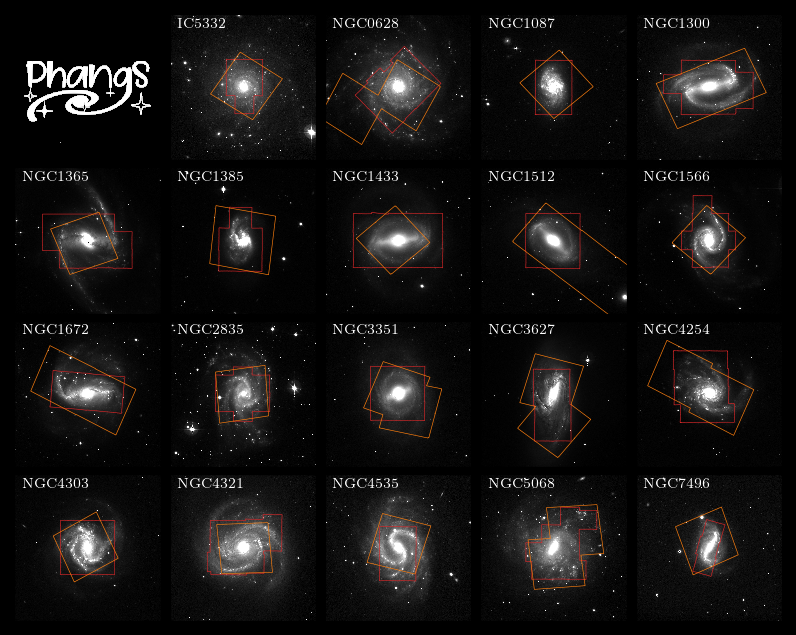

In [6]:
from astropy.nddata import Cutout2D
from cluster.regions import find_sky_region

sample = set([x.stem.split('_')[0].upper() for x in (data_ext/'HST'/'white_light').iterdir()])
sample = np.unique(sample_table['name'])
ncols = 5
nrows = int(np.ceil(len(sample)/ncols))

width = two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows),facecolor='black')
axes_iter = iter(axes.flatten())

ax=next(axes_iter)
# plot the PHANGS logo in the top left axis
image = mpl.image.imread(str(basedir/'references'/'Logo_white.png'))
img = np.sum(image,axis=2)
img = np.pad(img,[(120,36),(25,25)],mode='constant')
ax.imshow(img,cmap=plt.cm.gray)
ax.axis('off')

hst_sample = []
for name in sorted(sample):
    
    print(name)
    
    filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{name.lower()}_f275w_v1_exp-drc-sci.fits'
    
    if filename.is_file():
        with fits.open(filename) as hdul:
            hst_whitelight = NDData(hdul[0].data,mask=hdul[0].data==0,meta=hdul[0].header,wcs=WCS(hdul[0].header))
            hst_whitelight.data[hst_whitelight.data==0] = np.nan
        hst_sample.append(name)

    
    filename = data_ext / 'MUSE' / 'DR2.1' / 'MUSEDAP' / f'{name}_MAPS.fits'
    with fits.open(filename) as hdul:
        Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                        uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                        mask=np.isnan(hdul['HA6562_FLUX'].data),
                        meta=hdul['HA6562_FLUX'].header,
                        wcs=WCS(hdul['HA6562_FLUX'].header))
        
    filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
    with fits.open(filename) as hdul:

        WFI = NDData(data=hdul[0].data,
                     meta=hdul[0].header,
                     wcs=WCS(hdul[0].header))
        

    reg_muse_pix, reg_muse_sky = find_sky_region(Halpha.mask.astype(int),wcs=Halpha.wcs)
    if name in hst_sample:
        reg_hst_pix, reg_hst_sky = find_sky_region(hst_whitelight.mask.astype(int),wcs=hst_whitelight.wcs)
    
    WFI_cutout = Cutout2D(WFI.data,sample_table.loc[name]['SkyCoord'],size=8*u.arcmin,wcs=WFI.wcs)
    
    # project from muse to hst coordinates
    reg_muse_wfi = reg_muse_sky.to_pixel(WFI_cutout.wcs)
    if name in hst_sample:
        reg_hst_wfi  = reg_hst_sky.to_pixel(WFI_cutout.wcs)

    ax = next(axes_iter)

    # plot image
    norm = simple_norm(WFI_cutout.data,clip=False,percent=99)
    ax.imshow(WFI_cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower')

    reg_muse_wfi.plot(ax=ax,ec='tab:red',label='MUSE',lw=0.3)
    if name in hst_sample:
        reg_hst_wfi.plot(ax=ax,ec='tab:orange',label='HST',lw=0.3)
    t = ax.text(0.05,0.91,name, transform=ax.transAxes,color='white',fontsize=7)
    #t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

    ax.set_xticks([])
    ax.set_yticks([])

for i in range(nrows*ncols-len(sample)-1):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

plt.subplots_adjust(wspace=-0.01,hspace=0.05)
plt.savefig(basedir/'reports'/'wfi_and_footprints.jpg',facecolor='black',dpi=600)

plt.show()

In [ ]:
from astropy.nddata import Cutout2D
from cluster.regions import find_sky_region


ncols = 5
nrows = int(np.ceil(len(muse_sample)/ncols))

width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

for name in sorted(muse_sample):
    
    print(name)
    
    catalogue_file = basedir/'..'/'PNLF'/'data'/'catalogues'/f'{name}_nebulae.txt'
    catalogue = ascii.read(catalogue_file,format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
    catalogue['SkyCoord'] = SkyCoord(catalogue['RaDec'])
    catalogue=catalogue[catalogue['type']=='PN']
    
    filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
    with fits.open(filename) as hdul:

        WFI = NDData(data=hdul[0].data,
                     meta=hdul[0].header,
                     wcs=WCS(hdul[0].header))
        
    
    WFI_cutout = Cutout2D(WFI.data,sample_table.loc[name]['SkyCoord'],size=5*u.arcmin,wcs=WFI.wcs)

    ax = next(axes_iter)

    # plot image
    norm = simple_norm(WFI_cutout.data,clip=False,percent=99)
    ax.imshow(WFI_cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower')
    
    x,y = catalogue['SkyCoord'].to_pixel(WFI_cutout.wcs)
    ax.scatter(x,y,marker='o',ec='tab:red',fc='none',s=1,lw=0.2)
    
    t = ax.text(0.05,0.91,name, transform=ax.transAxes,color='black',fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

    ax.set_xticks([])
    ax.set_yticks([])

for i in range(nrows*ncols-len(muse_sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

plt.subplots_adjust(wspace=-0.01,hspace=0.05)
plt.savefig(basedir/'reports'/'all_objects_PN.pdf',dpi=600)
plt.show()

In [ ]:
from astropy.nddata import Cutout2D
from cluster.regions import find_sky_region


ncols = 5
nrows = int(np.ceil(len(muse_sample)/ncols))

width = 1.5*two_column
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
axes_iter = iter(axes.flatten())

for name in sorted(muse_sample):
    
    print(name)
    
    catalogue = filter_table(nebulae,gal_name=name)
    #catalogue['SkyCoord'] = SkyCoord(catalogue['RaDec'])
    
    filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
    with fits.open(filename) as hdul:
        WFI = NDData(data=hdul[0].data,
                     meta=hdul[0].header,
                     wcs=WCS(hdul[0].header))
        
    
    WFI_cutout = Cutout2D(WFI.data,sample_table.loc[name]['SkyCoord'],size=5*u.arcmin,wcs=WFI.wcs)

    ax = next(axes_iter)

    # plot image
    norm = simple_norm(WFI_cutout.data,clip=False,percent=99)
    ax.imshow(WFI_cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower')
    
    x,y = catalogue['SkyCoord'].to_pixel(WFI_cutout.wcs)
    ax.scatter(x,y,marker='o',ec='tab:blue',fc='none',s=1,lw=0.2)
    
    t = ax.text(0.05,0.91,name, transform=ax.transAxes,color='black',fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

    ax.set_xticks([])
    ax.set_yticks([])

for i in range(nrows*ncols-len(muse_sample)):

    # remove the empty axes at the bottom
    ax = next(axes_iter)
    ax.remove()

plt.subplots_adjust(wspace=-0.01,hspace=0.05)
plt.savefig(basedir/'reports'/'all_objects_nebulae.pdf',dpi=600)
plt.show()

### Map of the sky

In [ ]:
from astropy.coordinates import Distance

sample = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample['SkyCoord'] = SkyCoord(sample['R.A.'],sample['Dec.'])
sample['d/Mpc'] = Distance(distmod=sample['(m-M)'])

ra = sample['SkyCoord'].ra
ra = ra.wrap_at(180*u.degree)
dec = sample['SkyCoord'].dec

In [ ]:
#mpl.use('pdf')
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian,dec.radian,marker='.')
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

d_max = np.max(sample['d/Mpc'])
width0 = 0.3 # in radian
for x,y,name,distance in zip(ra,dec,sample['name'],sample['d/Mpc']):
            
    filename = next((data_ext/'MUSE'/'DR2.1'/'copt'/'MUSEDAP').glob(f'{name}*.fits'))
    copt_res = float(filename.stem.split('-')[1].split('asec')[0])
    with fits.open(filename) as hdul:
        Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                        uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                        mask=np.isnan(hdul['HA6562_FLUX'].data),
                        meta=hdul['HA6562_FLUX'].header,
                        wcs=WCS(hdul['HA6562_FLUX'].header))
        
    img_width,img_height = Halpha.data.shape
    width  = width0 * distance / d_max
    height = width/img_width*img_height
    bounds = [x.radian-width/2,y.radian-height/2,width,height]

    ax_img = ax.inset_axes(bounds,transform=ax.transData)
    norm = simple_norm(Halpha.data,clip=False,percent=99)
    ax_img.imshow(Halpha.data,cmap=plt.cm.gray_r,norm=norm,origin='lower')
    ax_img.axis('off')
    ax_img.set_title(name)
        
    #ax.annotate(s,(x.radian,y.radian),xycoords='data',size='x-small')

fig.savefig("sky_map.pdf",dpi=600)
    

## Overlap between catalogues


In [ ]:
# choose which version of the association catalogue to use
version = 'v1p2'
HSTband = 'nuv'
scalepc = 32
gal_name = 'NGC0628'

with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{gal_name}_{HSTband}_{scalepc}pc_nebulae.yml') as f:
    nebulae_dict = yaml.load(f,Loader=yaml.SafeLoader)

In [ ]:
overlap = nebulae[['gal_name','region_ID']]
overlap.add_index(['gal_name','region_ID'])
overlap['nuv12pc'] = 0

for k,v in nebulae_dict.items():
    overlap[(overlap['gal_name']==gal_name) & (overlap['region_ID']==k)]['nuv12pc'][0] = len(v)

In [ ]:
overlap[(overlap['gal_name']==gal_name) & (overlap['region_ID']==k)]

In [ ]:
overlap.loc[['NGC0628',12]]

## Others

### create a LaTeX table for the journal

In [ ]:
catalogue['RA_asc'],catalogue['DEC_asc'] = zip(*[x.split(' ') for x in catalogue['SkyCoord_asc'].to_string(style='hmsdms',precision=2)])
catalogue['RA_neb'],catalogue['DEC_neb'] = zip(*[x.split(' ') for x in catalogue['SkyCoord_neb'].to_string(style='hmsdms',precision=2)])
catalogue['logmass'] = np.log10(catalogue['mass'])
catalogue['logmass_err'] = catalogue['mass_err'] / catalogue['mass']
catalogue['dots'] = '$\hdots$'

In [ ]:
# one large table
columns = ['gal_name','region_ID','RA_neb','DEC_neb','[SIII]/[SII]','[SIII]/[SII]_err','Delta_met_scal','met_scal_err','HA/FUV','HA/FUV_err','eq_width','EBV_balmer','EBV_balmer_err','overlap_neb','assoc_ID','RA_asc','DEC_asc','age','age_err','mass','mass_err','EBV_stars','EBV_stars_err','overlap_asc']
# create LaTeX table for a single galaxy (for paper)
tmp = catalogue[columns]


for col in columns:
    if not col.startswith('RA') and not col.startswith('DEC') and col!='gal_name':
        tmp[col].info.format = '%.2f'

ascii.write(tmp[-10:],sys.stdout,Writer=ascii.Latex,overwrite=True,exclude_names=['x','y','fwhm'])


In [ ]:
# or two separate tables
# for the associations
columns = ['gal_name','assoc_ID','RA_asc','DEC_asc','age','age_err','logmass','logmass_err','EBV_stars','EBV_stars_err','overlap_asc','dots']
# create LaTeX table for a single galaxy (for paper)
tmp = catalogue[columns]


for col in columns:
    if not col.startswith('RA') and not col.startswith('DEC') and col!='gal_name' and col!='dots':
        tmp[col].info.format = '%.2f'
tmp['assoc_ID'].info.format = '%.0f'
        
ascii.write(tmp[:10],sys.stdout,Writer=ascii.Latex,overwrite=True,exclude_names=['x','y','fwhm'])


# and now for the HII regions
columns = ['dots','region_ID','RA_neb','DEC_neb','[SIII]/[SII]','[SIII]/[SII]_err','Delta_met_scal','met_scal_err','HA/FUV','HA/FUV_err','eq_width','EBV_balmer','EBV_balmer_err','overlap_neb']
# create LaTeX table for a single galaxy (for paper)
tmp = catalogue[columns]

for col in columns:
    if not col.startswith('RA') and not col.startswith('DEC') and col!='gal_name' and col!='dots':
        tmp[col].info.format = '%.2f'
tmp['region_ID'].info.format = '%.0f'

ascii.write(tmp[:10],sys.stdout,Writer=ascii.Latex,overwrite=True,exclude_names=['x','y','fwhm'])




## Playground

### Measure DIG

In [ ]:
def measure_dig(data,mask,label,position,factor=1,max_iter=10,size=32,plot=False):
    '''measure the diffuse ionized gas around an HII-region'''
    
    cutout_mask = Cutout2D(mask.data,position,size=(size,size),mode='partial',fill_value=np.nan)
    cutout_data = Cutout2D(data.data,position,size=(size,size),mode='partial',fill_value=np.nan)
    
    area_mask  = np.sum(cutout_mask.data==label)
    input_mask = cutout_mask.data==label
    
    n_iter = 0
    while True:
        n_iter+=1
        boundaries = find_boundaries(input_mask,mode='outer')
        input_mask |=boundaries
        area_boundary = np.sum(input_mask & np.isnan(cutout_mask.data)) 
        if area_boundary > factor*area_mask or n_iter>max_iter: break
            
    if plot:
        fig,ax=plt.subplots(figsize=(5,5))
        ax.imshow(cutout_mask.data,origin='lower')
        mask = np.zeros((*cutout_mask.shape,4))
        mask[input_mask & np.isnan(cutout_mask.data),:] = (1,0,0,0.5)
        ax.imshow(mask,origin='lower')
        plt.show()
        
    #if np.sum(boundaries & np.isnan(cutout_mask.data))==0:
    #    print(f'no boundaries for {label}')
    dig = cutout_data.data[input_mask & np.isnan(cutout_mask.data)]

    return np.median(dig),np.mean(dig),np.sum(dig)



### Old and young populations

In [ ]:
from regions import read_ds9

tmp = catalogue[catalogue['gal_name']=='NGC1365']

# filter image with uncertainties
filename = data_ext / 'HST' / 'filterImages' / f'NGC1365_uvis_f275w_exp_drc_sci.fits'
with fits.open(filename) as hdul:
    F275 = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))

associations,associations_mask = read_associations(folder=data_ext/'HST',target='NGC1365',scalepc=32)
reg_young, reg_old = read_ds9(basedir/'data'/'tmp'/'young_old.reg')

# the catalogue
young_sample = tmp[reg_young.contains(tmp['SkyCoord_asc'],wcs=associations_mask.wcs)]
young_sample = young_sample[young_sample['age']<20]
old_sample = tmp[reg_old.contains(tmp['SkyCoord_asc'],wcs=associations_mask.wcs)]
old_sample = old_sample[old_sample['age']>20]

In [ ]:
# the maps
young = np.isin(associations_mask.data,associations[associations['age']<10]['assoc_ID'])
old   = np.isin(associations_mask.data,associations[associations['age']>10]['assoc_ID'])

young = young.astype(float)
young[young==0] = np.nan

old = old.astype(float)
old[old==0] = np.nan

In [ ]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=F275.wcs)

norm = simple_norm(F275.data,clip=False,percent=99)
ax.imshow(F275.data,norm=norm,origin='lower',cmap=plt.cm.Greys,alpha=0.5)
ax.imshow(old,vmin=0,vmax=1,cmap=plt.cm.Reds,alpha=0.8)
ax.imshow(young,vmin=0,vmax=1,cmap=plt.cm.Blues,alpha=0.8)

reg_young_pix = reg_young.to_pixel(F275.wcs)
reg_old_pix = reg_old.to_pixel(F275.wcs)

ax.add_artist(reg_young_pix.as_artist())
ax.add_artist(reg_old_pix.as_artist())


ax.set(xlim=[2000,5000],ylim=[3000,5000])
plt.show()

In [ ]:
xlim = [0,10]


fig,ax=plt.subplots(figsize=(single_column,single_column))

sc = ax.scatter(young_sample['EBV_stars'],young_sample['EBV_balmer'],color='g',label='upper arm')
sc = ax.scatter(old_sample['EBV_stars'],old_sample['EBV_balmer'],color='m',label='lower arm')
ax.legend()
ax.plot([0,1],[0,2],color='black')
ax.plot([0,2],[0,2],color='black')
#fig.colorbar(sc,label='age / Myr',cax=cax)
ax.set(xlim=[0,0.7],ylim=[0,0.7],xlabel='E(B-V) stars',ylabel='E(B-V) Balmer')

plt.show()

### Deproject radii

In [ ]:
from pnlf.auxiliary import project

def r25(name,table):
    '''calculate deprojected r25
    
    '''

    # get the pixel position of the centre
    with fits.open(data_ext/'MUSE_DR2.1'/'MUSEDAP'/f'{name}_MAPS.fits') as hdul:
        wcs = WCS(hdul['FLUX'].header)
    centre = sample_table.loc[name]['SkyCoord']
    x_cen,y_cen = centre.to_pixel(wcs)
    
    pa  = sample_table.loc[name]['posang']
    inc = sample_table.loc[name]['Inclination']
    r25 = sample_table.loc[name]['r25']*u.arcmin
    
    # deproject
    x_depr,y_depr = project(table['x_neb']-x_cen,table['y_neb']-y_cen,pa,inc)
    skycoord_depr = SkyCoord.from_pixel(x_depr+x_cen,y_depr+y_cen,wcs)
    
    # separation to centre
    sep = skycoord_depr.separation(centre)
    
    return (sep/r25).decompose()

name = 'NGC0628'

# the catalogue with the positions
tmp = nebulae[nebulae['gal_name']==name]

r25(name,tmp)

### Look at units of FUV and Halpha

In [ ]:
from starburst import Cluster, find_model, make_folder, list_available_models

cluster = Cluster(stellar_model='GENEVAv40',metallicity=0.014)
cluster.measure_FUV()

In [ ]:
from speclite.filters import FilterResponse, load_filters, plot_filters

response_curve = ascii.read(basedir/'data'/'external'/'astrosat_response_curve.txt',
                                     names=['wavelength','EA','Filter'])

F148W_mask = response_curve['Filter']=='F148W'
F148W_lam = response_curve['wavelength'][F148W_mask]*u.angstrom
F148W_res = response_curve['EA'][F148W_mask] / max(response_curve['EA'][F148W_mask])
F148W = FilterResponse(F148W_lam,F148W_res,meta=dict(group_name='Astrosat',band_name='F148W'))

F154W_mask = response_curve['Filter']=='F154W'
F154W_lam  = response_curve['wavelength'][F154W_mask]*u.angstrom
F154W_res  = response_curve['EA'][F154W_mask] / max(response_curve['EA'][F154W_mask])
F154W = FilterResponse(F154W_lam,F154W_res,meta=dict(group_name='Astrosat',band_name='F154W'))

astrosat_filter = load_filters('Astrosat-F148W', 'Astrosat-F154W')
plot_filters(astrosat_filter)

In [ ]:
age = 1e6 * u.yr

# find closest availalbe age
ages=cluster.spectrum['Time']
age =ages[np.argmin(np.abs(ages-age))]

wavelength = cluster.spectrum[cluster.spectrum['Time']==age]['Wavelength']
spectrum   = cluster.spectrum[cluster.spectrum['Time']==age]['Total']

ages=cluster.uvline['Time']
age =ages[np.argmin(np.abs(ages-age))]
wavelength_uv = cluster.uvline[cluster.uvline['Time']==age]['Wavelength']
spectrum_uv   = cluster.uvline[cluster.uvline['Time']==age]['lum']

fig,ax=plt.subplots()
ax.plot(wavelength,spectrum,color='tab:red')
ax.plot(wavelength_uv,spectrum_uv,color='tab:blue')
ax.set(xlim=[1000,2000],yscale='log',ylim=[1e38,1e40],
       xlabel='wavelength / AA',ylabel='erg / s / AA')

plt.show()

In [ ]:
# compare different methods to calculate FUV from starburst99
age = np.unique(cluster.uvline['Time'])[4]

wavelength = cluster.uvline['Wavelength'][cluster.uvline['Time']==age]
spectrum   = cluster.uvline['lum'][cluster.uvline['Time']==age]
print(f'uvline,   filter: {np.mean(np.interp(wavelength,F148W_lam,F148W_res)*spectrum):.2g}')

mask = (wavelength>1250*u.angstrom) & (wavelength<1800*u.angstrom)
print(f'uvline,   range:  {np.mean(spectrum[mask]):.2g}')

wavelength = cluster.spectrum['Wavelength'][cluster.spectrum['Time']==age]
spectrum   = cluster.spectrum['Total'][cluster.spectrum['Time']==age]
print(f'spectrum, filter: {np.mean(np.interp(wavelength,F148W_lam,F148W_res)*spectrum):.2g}')

mask = (wavelength>1250*u.angstrom) & (wavelength<1800*u.angstrom)
print(f'spectrum, range:  {np.mean(spectrum[mask]):.2g}')


In [ ]:
from starburst import Cluster, find_model, make_folder, list_available_models

fig,ax=plt.subplots(figsize=(single_column,single_column/1.618))

for stellar_model in [41,42,43,44,45]:
    cluster = Cluster(stellar_model=stellar_model)
    cluster.measure_FUV()
    _,_,metallicity,_ = find_model(stellar_model)
    
    ax.plot(cluster.ewidth['Time']/1e6,
            cluster.ewidth['Luminosity_H_A']/cluster.FUV['FUV'],
            label=f'Z={metallicity}')

ax.legend()
ax.set(xlim=[0,10],xlabel='age / Myr',ylabel=r'H$\alpha$ / FUV')
#ax.set_title('Geneva Tracks with Rotation')

plt.savefig(basedir/'reports'/'HaFUV_starburst99_padova.pdf',dpi=400)
plt.savefig(basedir/'reports'/'HaFUV_starburst99_padova.png',dpi=400)

plt.show()

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,0.75*two_column/2))

ax1.plot(cluster.ewidth['Time']/1e6,cluster.ewidth['Luminosity_H_A']/cluster.FUV['FUV'])
ax1.set(xlim=[0,10],xlabel='age / Myr',ylabel=r'H$\alpha$ / FUV')

ax2.plot(cluster.ewidth['Time']/1e6,cluster.ewidth['eq_width_H_A'])
ax2.set(xlim=[0,10],xlabel='age / Myr',ylabel=r'EW(H$\alpha$)')
plt.tight_layout()

#plt.savefig(basedir/'reports'/'HaFUV.pdf')
plt.show()

In [ ]:
age = 1e6 * u.yr

# find closest availalbe age
ages=cluster.spectrum['Time']
age =ages[np.argmin(np.abs(ages-age))]

wavelength = cluster.spectrum[cluster.spectrum['Time']==age]['Wavelength']
spectrum   = cluster.spectrum[cluster.spectrum['Time']==age]['Total']

fig,ax=plt.subplots()
ax.plot(wavelength,spectrum)
ax.set(xlim=[500,8000],yscale='log',ylim=[1e35,1e40])

ax2 = ax.twinx()
ax2.plot(response_curve['lam'],response_curve['r'],color='grey')

plt.show()

### 2D density histogram

In [ ]:
from scipy.stats import binned_statistic_2d
from scipy.interpolate import interpn

x = np.array([0.5,0.3,0.5,3.5])
y = np.array([0.5,0.6,2.5,1.5])
z = np.array([7.2,7.8,6.5,7.9])

xlim,ylim=[0,4],[0,4]

def hist_scatter(x,y,z,xlim,ylim):
    
    hist , x_e, y_e    = np.histogram2d(x,y, bins=4,range =[xlim,ylim], density=True)
    mean , x_e, y_e, _ = binned_statistic_2d(x,y,z,bins=4,range = [xlim,ylim])
    z = interpn((0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ),mean,np.vstack([x,y]).T,method="nearest",bounds_error=False)

    fig,ax=plt.subplots()
    cmap = plt.cm.get_cmap('gray_r',4)
    im = ax.imshow(mean.T,origin='lower',cmap=cmap,extent=[*xlim,*ylim],vmin=0,vmax=2)
    sc=ax.scatter(x,y,c=z,cmap=plt.cm.viridis,vmin=6,vmax=8)
    fig.colorbar(sc)
    ax.set(xlim=xlim,ylim=ylim)
    plt.show()
    
hist_scatter(x,y,z,xlim,ylim)

### Measure NUV

In [ ]:
from astropy.nddata import InverseVariance

gal_name = 'NGC2835'

filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_exp-drc-sci.fits'
error_file = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_err-drc-wht.fits'

if not filename.is_file():
    print(f'no NUV data for {gal_name}')
else:
    with fits.open(filename) as hdul:
        F275 = NDData(hdul[0].data,
                        mask=hdul[0].data==0,
                        meta=hdul[0].header,
                        wcs=WCS(hdul[0].header))
        with fits.open(error_file) as hdul:
            F275.uncertainty = InverseVariance(hdul[0].data)

In [ ]:
from cluster.io import read_associations

HSTband = 'nuv'

NUV_fluxes = {}
NUV_fluxes_err = {}
for scalepc in [8,16,32,64]:
    print(f'working on {scalepc}pc')
    associations, associations_mask = read_associations(folder=data_ext/'Products'/'stellar_associations',
                                                        target=gal_name.lower(),scalepc=scalepc,
                                                        HSTband='nuv',version='v1p2',data='all')

    # measure flux in mask and covert to physical units
    std_err_map = np.sqrt(1/F275.uncertainty.array)

    NUV = [np.sum(F275.data[associations_mask.data==assoc_ID]) for assoc_ID in associations['assoc_ID']]
    NUV_err = [np.sqrt(np.sum(std_err_map[associations_mask.data==assoc_ID]**2)) for assoc_ID in associations['assoc_ID']]

    NUV_mJy = 1e3*np.array(NUV)* F275.meta['PHOTFNU']*u.mJy
    NUV_mJy_err = 1e3*np.array(NUV_err)* F275.meta['PHOTFNU']*u.mJy

    NUV_flam = np.array(NUV)* F275.meta['PHOTFLAM']
    NUV_flam_err = np.array(NUV_err)* F275.meta['PHOTFLAM']
    
    NUV_fluxes[scalepc] = NUV_mJy
    NUV_fluxes_err[scalepc] = NUV_mJy_err

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))

ax1.scatter(associations['NUV_dolflux_mjy'],NUV_mJy,s=1)
ax1.plot([5e-5,1],[5e-5,1],color='black')
ax1.set(xlim=[5e-5,1e0],ylim=[5e-5,1e0],xscale='log',yscale='log',
        xlabel='NUV / mJy from catalogue',ylabel='NUV / mJy from image')
ax1.set_title(r'using \texttt{PHOTFNU}')


# we are missing a factor 100 in the untis here
ax2.scatter(associations['NUV_FLUX'],NUV_flam,s=1)
ax2.plot([5e-19,5e-13],[5e-19,5e-13],color='black')
ax2.set(xlim=[5e-19,5e-15],ylim=[5e-19,5e-15],xscale='log',yscale='log',
        xlabel=r'NUV / erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$ from catalogue',ylabel=r'NUV / erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$ from image')
ax2.set_title(r'using \texttt{PHOTFLAM}')

#fig.suptitle(f'{gal_name}, NUV (F275W) for {scalepc}pc associations')
plt.tight_layout()

plt.savefig(basedir/'reports'/f'remeasure_NUV_{gal_name}_{scalepc}pc.pdf')

plt.show()

In [ ]:
(F275.meta['PHOTFNU']*u.Jy).to(u.erg/u.s/u.cm**2/u.Angstrom,equivalencies=u.spectral_density(2704*u.AA))

In [ ]:
F275.meta['PHOTFLAM']*u.erg/u.s/u.cm**2/u.Angstrom

In [ ]:
fig,axes=plt.subplots(ncols=4,figsize=(1.5*two_column,two_column/4*1.5))

for scalepc,ax in zip([8,16,32,64],axes):
    
    associations = read_associations(folder=data_ext/'Products'/'stellar_associations',
                                     target=gal_name.lower(),scalepc=scalepc,
                                     HSTband='nuv',version='v1p2',data='catalogue')
    
    dif = np.mean((associations['NUV_dolflux_mjy']-1.67*NUV_fluxes[scalepc].value)/associations['NUV_dolflux_mjy'])
    ax.scatter(associations['NUV_dolflux_mjy'],1.67*NUV_fluxes[scalepc],s=1)
    ax.plot([5e-5,1],[5e-5,1],color='black')
    ax.set(xlim=[5e-5,1e0],ylim=[5e-5,1e0],xscale='log',yscale='log',
            xlabel='NUV / mJy from catalogue',ylabel='NUV / mJy from image')
    ax.set_title(f'{scalepc}pc ({100*dif:.2f}\% smaller)')


#fig.suptitle(f'{gal_name}, NUV (F275W) for {scalepc}pc associations')
plt.tight_layout()

plt.savefig(basedir/'reports'/f'remeasure_NUV_all_resolutions_{gal_name}.pdf')

plt.show()

now measure FUV inside the nebula mask

In [ ]:
from dust_extinction.parameter_averages import O94, CCM89
from astropy.nddata import NDData, StdDevUncertainty, InverseVariance

HSTbands_wave = {'NUV':2704*u.AA,'U':3355*u.AA,'B':4325*u.AA,'V':5308*u.AA,'I':8024*u.AA}
freq_to_wave = lambda band: u.mJy.to(u.erg/u.s/u.cm**2/u.Angstrom,equivalencies=u.spectral_density(HSTbands_wave[band]))

extinction_model = O94(Rv=3.1)

def extinction(EBV,EBV_err,wavelength,plot=False):
    '''Calculate the extinction for a given EBV and wavelength with errors'''
    
    EBV = np.atleast_1d(EBV)
    sample_size = 100000

    ext = extinction_model.extinguish(wavelength,Ebv=EBV)
    
    EBV_rand = np.random.normal(loc=EBV,scale=EBV_err,size=(sample_size,len(EBV)))
    ext_arr  = extinction_model.extinguish(wavelength,Ebv=EBV_rand)
        
    ext_err  = np.std(ext_arr,axis=0)
    ext_mean = np.mean(ext_arr,axis=0)
 
    return ext,ext_err


# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(data_ext / 'Products' / 'Nebulae catalogue' / 'Nebulae_catalogue_v2.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['NUV_FLUX'] = np.nan
nebulae['NUV_FLUX_ERR'] = np.nan
nebulae['NUV_FLUX_CORR'] = np.nan
nebulae['NUV_FLUX_CORR_ERR'] = np.nan

In [ ]:
gal_name = 'NGC1365'

print(f'start with {gal_name}')
p = {x:sample_table.loc[gal_name][x] for x in sample_table.columns}

filename = data_ext / 'MUSE'/ 'DR2.1' / 'MUSEDAP' / f'{gal_name}_MAPS.fits'
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))

filename = data_ext / 'Products' / 'Nebulae catalogue' /'spatial_masks'/f'{gal_name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

print(f'read in nebulae catalogue')

# NUV image
filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_exp-drc-sci.fits'
error_file = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_err-drc-wht.fits'

with fits.open(filename) as hdul:
    F275 = NDData(hdul[0].data,
                    mask=hdul[0].data==0,
                    meta=hdul[0].header,
                    wcs=WCS(hdul[0].header))
    with fits.open(error_file) as hdul:
        F275.uncertainty = InverseVariance(hdul[0].data)
print(f'read in HST data')

In [ ]:
from astrotools.regions import Regions
from reproject import reproject_interp

muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)
hst_regions = muse_regions.reproject(F275.meta)
print('regions reprojected')

muse_reproj, footprint = reproject_interp((nebulae_mask.mask,nebulae_mask.wcs),F275.meta)
mean,median,std=sigma_clipped_stats(F275.data[footprint.astype(bool)])
print('measuring sigma_clipped_stats')

tmp = nebulae[nebulae['gal_name']==gal_name]

std_err_map = np.sqrt(1/F275.uncertainty.array)

flux = np.array([np.sum(F275.data[hst_regions.mask==ID]) for ID in tmp['region_ID']])
err  = np.array([np.sqrt(np.sum(std_err_map[hst_regions.mask==ID]**2)) for ID in tmp['region_ID']])

# convert counts to physical units
flux = np.array(flux) * F275.meta['PHOTFLAM']
err  = np.array(err) * F275.meta['PHOTFLAM']
print('measuring flux')

# E(B-V) is estimated from nebulae. E(B-V)_star = 0.5 E(B-V)_nebulae. NUV comes directly from stars
extinction_mw  = extinction_model.extinguish(2704*u.angstrom,Ebv=0.5*p['E(B-V)'])
ext_int,ext_int_err = extinction(0.5*tmp['EBV'],tmp['EBV_ERR'],wavelength=2704*u.angstrom)

nebulae['NUV_FLUX'][nebulae['gal_name']==gal_name] = 1e20*flux / extinction_mw
nebulae['NUV_FLUX_ERR'][nebulae['gal_name']==gal_name] = 1e20*err / extinction_mw

nebulae['NUV_FLUX_CORR'][nebulae['gal_name']==gal_name] = 1e20*flux / extinction_mw / ext_int 
nebulae['NUV_FLUX_CORR_ERR'][nebulae['gal_name']==gal_name] =  nebulae['NUV_FLUX_CORR'][nebulae['gal_name']==gal_name] *np.sqrt((err/flux)**2 + (ext_int_err/ext_int)**2)  

print('extinction correction and write to catalogue\n')

### Errors of FUV

In [ ]:
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_fuv.fits') as hdul:
    fuv = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/'old'/f'Nebulae_Catalogue_v2p1_fuv.fits') as hdul:
    fuv_old = Table(hdul[1].data)

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))

tmp = fuv_old[fuv_old['gal_name']=='NGC3627']
ax1.hist(tmp['FUV_FLUX'],bins=np.logspace(2,5,12))
ax1.set(xscale='log')

tmp = fuv[fuv['gal_name']=='NGC3351']
ax2.hist(tmp['FUV_FLUX'],bins=np.logspace(2,5,12))
ax2.set(xscale='log')

plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column))

lim = [1e2,1e6]

fuv_flux_old = fuv_old['FUV_FLUX_CORR'][fuv['gal_name']!='NGC3351']
fuv_flux_new = fuv['FUV_FLUX_CORR'][fuv['gal_name']!='NGC3351']
ax.scatter(fuv_old['FUV_FLUX_CORR'][fuv['gal_name']=='NGC3351'],fuv['FUV_FLUX'][fuv['gal_name']=='NGC3351'],alpha=0.6,label='NGC3351',s=0.8)
ax.scatter(fuv_flux_old,fuv_flux_new,alpha=0.6,label='not NGC3351',s=0.8)
print(f'difference {100*np.nanmean((fuv_flux_old-fuv_flux_new)/fuv_flux_old):.2f}%')
ax.plot(lim,lim,color='black')
ax.legend()

ax.set(xscale='log',yscale='log',xlim=lim,ylim=lim,
       xlabel='FUV old',ylabel='FUV new')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column/1.618))

bins = np.logspace(-1,2)
ax.hist(fuv['FUV_FLUX_CORR']/fuv['FUV_FLUX_CORR_ERR'],bins=bins)
ax.set(xscale='log',xlim=[0.1,1e2],xlabel=r'FUV/ $\delta$FUV')
mean_ston = np.nanmean(fuv['FUV_FLUX_CORR']/fuv['FUV_FLUX_CORR_ERR'])
ax.set_title(f'mean S/N={mean_ston:.2f}')
plt.savefig(basedir/'reports'/'benchmarks'/'FUV_StoN.pdf',dpi=300)
plt.show()

In [ ]:
fuv['FUV_FLUX_ERR_NEW'] = np.nan
fuv['IntTime'] = np.nan
fuv['CTSTOFLUX'] = np.nan
for gal_name in np.unique(fuv['gal_name']):
    astro_file = data_ext /'Astrosat' / f'{gal_name}_FUV_F148W_flux_reproj.fits'
    if not astro_file.is_file():
        astro_file = data_ext /'Astrosat' / f'{gal_name}_FUV_F154W_flux_reproj.fits'
        if not astro_file.is_file():
            print(f'no astrosat file for {gal_name}')
            continue
            
    with fits.open(astro_file) as hdul:
        for row in hdul[0].header['COMMENT']:
            if row.startswith('CTSTOFLUX'):
                _,CTSTOFLUX = row.split(':')
                CTSTOFLUX = float(CTSTOFLUX)
            if row.startswith('IntTime'):
                _,IntTime = row.split(':')
                IntTime = float(IntTime)
        header=hdul[0].header
    break

In [ ]:
 np.nanmean(100*(fuv['FUV_FLUX_ERR']-fuv['FUV_FLUX_ERR_NEW'])/fuv['FUV_FLUX_ERR'])

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column))

lim = [1e2,2e3]

for gal_name in np.unique(fuv['gal_name']):
    tmp = fuv[fuv['gal_name']==gal_name]
    ax.scatter(tmp['FUV_FLUX_ERR'],tmp['FUV_FLUX_ERR_NEW'],c=tmp['IntTime']/60,vmin=0,vmax=100)

ax.plot(lim,lim,color='black')

ax.set(xscale='log',yscale='log',xlim=lim,ylim=lim)
plt.show()


In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column))

lim = [5e2,5e8]

ax.scatter(nebulae['HA6562_FLUX_CORR'],nebulae['HA_conv_FLUX_CORR'])

ax.plot(lim,lim,color='black')

ax.set(xscale='log',yscale='log',xlim=lim,ylim=lim,
       xlabel=r'H$\alpha$ catalogue',ylabel=r'H$\alpha$ from convolved image')
plt.savefig(basedir/'reports'/'benchmarks'/'Halpha_convolved.pdf',dpi=300)
plt.show()


In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column))

lim = [5e-3,5e5]

ax.scatter(nebulae['HA6562_FLUX_ERR'],nebulae['HA_conv_FLUX_ERR'])

ax.plot(lim,lim,color='black')

ax.set(xscale='log',yscale='log',xlim=lim,ylim=lim,
       xlabel=r'H$\alpha$ Error catalogue',ylabel=r'H$\alpha$ Error from convolved image')
#plt.savefig(basedir/'reports'/'benchmarks'/'Halpha_convolved.pdf',dpi=300)
plt.show()


In [ ]:
fig,ax=plt.subplots()

sc = ax.scatter(fuv['FUV_FLUX'],fuv['FUV_FLUX']/fuv['FUV_FLUX_ERR'],c=fuv['IntTime']/60)
ax.set(xscale='log',xlim=[7e1,2e6],yscale='log',ylim=[1,100],
       xlabel='FUV flux',ylabel='S/N FUV')
fig.colorbar(sc,label='Integration time / min')
plt.show()

In [ ]:
from astrotools.regions import Regions

# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(data_ext / 'Products' / 'Nebulae catalogue'/ 'Nebulae_catalogue_v2.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')

nebulae['FUV_FLUX'] = np.nan
nebulae['FUV_FLUX_ERR'] = np.nan
nebulae['FUV_FLUX_CORR'] = np.nan
nebulae['FUV_FLUX_CORR_ERR'] = np.nan

nebulae['HA_conv_FLUX'] = np.nan
nebulae['HA_conv_FLUX_ERR'] = np.nan
nebulae['HA_conv_FLUX_CORR'] = np.nan
nebulae['HA_conv_FLUX_CORR_ERR'] = np.nan


gal_name = 'NGC1566'
        
print(f'start with {gal_name}')

print(f'read in nebulae catalogue')
filename = next((data_ext/'MUSE'/'DR2.1'/'copt').glob(f'{gal_name}*.fits'))
copt_res = float(filename.stem.split('-')[1].split('asec')[0])
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))

filename = data_ext / 'Products' / 'Nebulae catalogue' /'spatial_masks'/f'{gal_name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

print(f'read in astrosat data')
astro_file = data_ext /'Astrosat' / f'{gal_name}_FUV_F148W_flux_reproj.fits'
if not astro_file.is_file():
    astro_file = data_ext /'Astrosat' / f'{gal_name}_FUV_F154W_flux_reproj.fits'
    if not astro_file.is_file():
        print(f'no astrosat file for {gal_name}')

with fits.open(astro_file) as hdul:
    d = hdul[0].data
    astrosat = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    for row in hdul[0].header['COMMENT']:
        if row.startswith('CTSTOFLUX'):
            _,CTSTOFLUX = row.split(':')
            CTSTOFLUX = float(CTSTOFLUX)
        if row.startswith('IntTime'):
            _,IntTime = row.split(':')
            IntTime = float(IntTime)


print('reproject regions')
muse_regions = Regions(mask=nebulae_mask.data,projection=nebulae_mask.meta,bkg=-1)
astrosat_regions = muse_regions.reproject(astrosat.meta)

tmp = nebulae[nebulae['gal_name']==gal_name]

In [ ]:
from skimage.measure import find_contours

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(two_column,two_column/2))

position = tmp[1]['SkyCoord']
size = 5*u.arcsec
Cutout_Halpha = Cutout2D(Halpha.data,position,size=size,wcs=Halpha.wcs)
Cutout_FUV = Cutout2D(astrosat.data,position,size=size,wcs=astrosat.wcs)
Cutout_mask = Cutout2D(astrosat_regions.mask,position,size=size,wcs=astrosat.wcs)
Cutout_mask_neb = Cutout2D(muse_regions.mask,position,size=size,wcs=Halpha.wcs)

norm = simple_norm(Cutout_Halpha.data,clip=False,percent=99)
ax1.imshow(Cutout_Halpha.data,norm=norm,origin='lower',cmap=plt.cm.Greens)
ax1.axis('off')

contours = []
region_ID = np.unique(Cutout_mask_neb.data[~np.isnan(Cutout_mask_neb.data)])
for i in region_ID:
    blank_mask = np.zeros_like(Cutout_mask_neb.data)
    blank_mask[Cutout_mask_neb.data==i] = 1
    contours += find_contours(blank_mask, 0.5)

for coords in contours:
    ax1.plot(coords[:,1],coords[:,0],color='tab:red',lw=1,label='association')

norm = simple_norm(Cutout_FUV.data,clip=False,percent=99)
ax2.imshow(Cutout_FUV.data,norm=norm,origin='lower',cmap=plt.cm.Blues)
ax2.axis('off')

ax2.imshow(Cutout_mask.data,origin='lower',cmap=plt.cm.gray,alpha=0.6)

contours = []
region_ID = np.unique(Cutout_mask.data[~np.isnan(Cutout_mask.data)])
for i in region_ID:
    blank_mask = np.zeros_like(Cutout_mask.data)
    blank_mask[Cutout_mask.data==i] = 1
    contours += find_contours(blank_mask, 0.5)

for coords in contours:
    ax2.plot(coords[:,1],coords[:,0],color='tab:red',lw=1,label='association')

plt.show()

In [ ]:
2.5*np.log10(np.sqrt(2*np.pi))+2.5*np.log10(std) + 2.5/np.log(10)*(x-mu)**2/(2*std**2)-13.74

In [ ]:
x = np.linspace(0.5e-17,1.5e-17)
plt.plot(-2.5*np.log10(x)-13.74,norm.pdf(x,1e-17,1e-18),color='blue')
plt.xlim((28,29.5))

plt.show()